In [41]:
import numpy as np
import pandas as pd
import SolveLinSys
import matplotlib.pyplot as plt
from numba import njit

import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
from scipy.interpolate import interp2d
from solver_2d import false_transient_one_iteration_python
from derivative import derivatives_2d

In [52]:
@njit
def compute_derivatives(data, dim, order, dlt):
    res = np.zeros_like(data)
    if order == 1:                    # first order derivatives
        if dim == 0:                  # to first dimension
            res[1:,:] = (1 / dlt) * (data[1:,:] - data[:-1,:])
            res[0,:] = (1 / dlt) * (data[1,:] - data[0,:])
        elif dim == 1:                # to second dimension
            res[:,1:] = (1 / dlt) * (data[:,1:] - data[:,:-1])
            res[:,0] = (1 / dlt) * (data[:,1] - data[:,0])        
    elif order == 2:
        if dim == 0:                  # to first dimension
            res[1:-1,:] = (1 / dlt ** 2) * (data[2:,:] + data[:-2,:] - 2 * data[1:-1,:])
            res[-1,:] = (1 / dlt ** 2) * (data[-1,:] + data[-3,:] - 2 * data[-2,:])
            res[0,:] = (1 / dlt ** 2) * (data[2,:] + data[0,:] - 2 * data[1,:])
        elif dim == 1:                # to second dimension
            res[:,1:-1] = (1 / dlt ** 2) * (data[:,2:] + data[:,:-2] - 2 * data[:,1:-1])
            res[:,-1] = (1 / dlt ** 2) * (data[:,-1] + data[:,-3] - 2 * data[:,-2])
            res[:,0] = (1 / dlt ** 2) * (data[:,2] + data[:,0] - 2 * data[:,1])    
    return res

def false_transient_one_iteration(stateSpace, A, B1, B2, C1, C2, D, v0, ε=.3, tol=-10):
    A = A.reshape(-1, 1, order='F')
    B = np.hstack([B1.reshape(-1, 1, order='F'), B2.reshape(-1, 1, order='F')])
    C = np.hstack([C1.reshape(-1, 1, order='F'), C2.reshape(-1, 1, order='F')])
    D = D.reshape(-1, 1, order='F')
    v0 = v0.reshape(-1, 1, order='F')
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)
    return out

PDE:
\begin{align*}
0 = \max_{\mathcal{E}}  &  -\delta \phi(y_1, y_2) + \eta \log \mathcal{E} \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} (-\lambda y_2 + \lambda \sum_{i=1}^m \pi^p_i \theta_i \mathcal{E})\\
&+ \frac{\eta-1}{\delta}\left[\gamma_1 + \gamma_2 y_1 + \gamma_2^+\boldsymbol{1}_{y_1\geq \bar{y}_1}(y_1-\bar{y}_1)\right]y_2\\
&+ \xi_a\sum_{i=1}^{n} \pi_i^c(\log \pi_i^c - \log \hat{\pi}_i^c)
\end{align*}

FOC of $\mathcal{E}$ gives:
$$
\mathcal{E} = -\frac{\eta}{\frac{\partial \phi}{\partial y_2} \lambda \sum_{i=1}^m \pi^d_i \theta_i}
$$

In [57]:
def false_transient(y1_grid, y2_grid, model_paras=(), v0=None, ϵ=.5, tol=1e-8, max_iter=10_000, print_all=True):
    η, δ, θ, γ_1, γ_2, γ_2p, y_bar, πc_o, ξ_a, λ = model_paras
    dy1 = y1_grid[1] - y1_grid[0]
    dy2 = y2_grid[1] - y2_grid[0]
    (y1_mat, y2_mat) = np.meshgrid(y1_grid, y2_grid, indexing = 'ij')
    stateSpace = np.hstack([y1_mat.reshape(-1, 1, order='F'), y2_mat.reshape(-1, 1, order='F')])    

    if v0 is None:
        v0 = -η*(y1_mat+y2_mat+(y1_mat+y2_mat)**2)
    e_tilde = np.array(0)

    d_Λ = γ_1 + γ_2*y1_mat + γ_2p*(y1_mat>y_bar)*(y1_mat-y_bar)

    πc = np.ones((len(πc_o), len(y1_grid), len(y2_grid)))
    θ_reshape = np.ones_like(πc)
    for i in range(πc.shape[0]):
        πc[i] = πc_o[i]
        θ_reshape[i] = θ[i]
    πc_o = πc.copy()
    θ = θ_reshape

    count = 0
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()
        e_tilde_old = e_tilde.copy()

        v0_dy1 = compute_derivatives(v0, 0, 1, dy1)
        v0_dy2 = compute_derivatives(v0, 1, 1, dy2)        
#         v0_dy1 = derivatives_2d(v0, 0, 1, dy1)
#         v0_dy2 = derivatives_2d(v0, 1, 1, dy2)          
        
        e_tilde = -η/(v0_dy2*λ*np.sum(πc*θ, axis=0))
        e_tilde[e_tilde<=0] = 1e-15
        e_tilde = e_tilde*.5 + e_tilde_old*.5

        log_πc_ratio = -v0_dy2*λ*e_tilde*θ/ξ_a
        πc_ratio = log_πc_ratio - np.max(log_πc_ratio, axis=0)
        πc = np.exp(πc_ratio) * πc_o
        πc[πc<=0] = 1e-16
        πc = πc/np.sum(πc, axis=0)
        c_entropy = np.sum(πc*(np.log(πc)-np.log(πc_o)), axis=0)

        A = np.ones_like(y1_mat) * (-δ)
        B1 = y2_mat
        B2 = λ*(-y2_mat+np.sum(πc_o*θ, axis=0)*e_tilde)
        C1 = np.zeros_like(y1_mat)
        C2 = np.zeros_like(y2_mat)
        D = η*np.log(e_tilde) + (η-1)/δ*d_Λ*y2_mat + ξ_a * c_entropy

        res = false_transient_one_iteration(stateSpace, A, B1, B2, C1, C2, D, v0, ϵ) # CG tol = 1e-10
        v0 = res[2].reshape(v0.shape, order = "F")

        rhs_error = A*v0 + B1*v0_dy1 + B2*v0_dy2 + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
        count += 1
        if print_all:
            print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

    print("Converged. Total iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

    res = {'v0': v0,
           'e_tilde': e_tilde}
    return res

In [58]:
ξ_a = 1./100
ξ_p = 5.

# λ = .116 # half life = 6 years
λ = np.log(2)/6 # half life = 6 years

η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)

y_bar = 2.
γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = np.array([0, .0197*2, .3853*2])
πd_o = np.array([1./3, 1./3, 1./3])

y1_step = .04
y1_grid_long = np.arange(0., 4., y1_step)
y1_grid_short = np.arange(0., 2.+y1_step, y1_step)

y2_step = .001
y2_grid = np.arange(0., .05, y2_step)

ϕ_i = []
ems_i = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, θ, γ_1, γ_2, γ_2p_i, y_bar, πc_o, ξ_a, λ)
    model_res = false_transient(y1_grid_long, y2_grid, model_paras,
                                v0=None, ϵ=.5, tol=1e-8, max_iter=3000, print_all=True)
    ϕ_i.append(model_res['v0'])
    ems_i.append(model_res['e_tilde'])

Iteration 1: LHS Error: 0.17063103370856317; RHS Error 0.23241194410363883
Iteration 2: LHS Error: 0.1531306266887033; RHS Error 0.17380951849505852
Iteration 3: LHS Error: 0.1849492612269706; RHS Error 0.2523263801525074
Iteration 4: LHS Error: 0.17825030876718662; RHS Error 0.3001325815293316
Iteration 5: LHS Error: 0.18004104964820072; RHS Error 0.2235153843886042
Iteration 6: LHS Error: 0.17557282933032572; RHS Error 0.25747893581142844
Iteration 7: LHS Error: 0.16112552816598547; RHS Error 0.2714479224824024
Iteration 8: LHS Error: 0.15022971578283434; RHS Error 0.1776929163099031
Iteration 9: LHS Error: 0.14266373578754; RHS Error 0.15664541523186884
Iteration 10: LHS Error: 0.137764414736798; RHS Error 0.1451805843053188
Iteration 11: LHS Error: 0.1344311272162202; RHS Error 0.13745297586851915
Iteration 12: LHS Error: 0.12895190278928337; RHS Error 0.1342301629081219
Iteration 13: LHS Error: 0.12299517288330541; RHS Error 0.12909658989544764
Iteration 14: LHS Error: 0.117515544

Iteration 115: LHS Error: 0.0340435329748372; RHS Error 0.03417585252662954
Iteration 116: LHS Error: 0.033797480505197264; RHS Error 0.03392898079388432
Iteration 117: LHS Error: 0.033553674193994354; RHS Error 0.033684343762538316
Iteration 118: LHS Error: 0.033312104189540115; RHS Error 0.033441938610814986
Iteration 119: LHS Error: 0.033072754770389956; RHS Error 0.03320175564976492
Iteration 120: LHS Error: 0.03283560485411563; RHS Error 0.03296377920651257
Iteration 121: LHS Error: 0.03260062928383878; RHS Error 0.032727988625261106
Iteration 122: LHS Error: 0.032367799539325226; RHS Error 0.03249435881985259
Iteration 123: LHS Error: 0.03213708452434716; RHS Error 0.03226286144309018
Iteration 124: LHS Error: 0.03190845128760689; RHS Error 0.03203346559259153
Iteration 125: LHS Error: 0.031681865681281174; RHS Error 0.03180613851760147
Iteration 126: LHS Error: 0.03145729295183841; RHS Error 0.031580846274726196
Iteration 127: LHS Error: 0.031234698257843085; RHS Error 0.0313575

Iteration 223: LHS Error: 0.016489545887212742; RHS Error 0.01657634628145524
Iteration 224: LHS Error: 0.016386455673279343; RHS Error 0.016473080057618134
Iteration 225: LHS Error: 0.016284100989548023; RHS Error 0.016370551993791713
Iteration 226: LHS Error: 0.016182475089911108; RHS Error 0.01626875531141775
Iteration 227: LHS Error: 0.016081571299682906; RHS Error 0.016167683304470645
Iteration 228: LHS Error: 0.01598138301415908; RHS Error 0.016067329337919822
Iteration 229: LHS Error: 0.01588190369737319; RHS Error 0.015967686846300025
Iteration 230: LHS Error: 0.015783126880803522; RHS Error 0.01586874933235033
Iteration 231: LHS Error: 0.015685046162499106; RHS Error 0.01577051036597807
Iteration 232: LHS Error: 0.01558765520612937; RHS Error 0.015672963583146543
Iteration 233: LHS Error: 0.015490947740167016; RHS Error 0.015576102685061613
Iteration 234: LHS Error: 0.015394917557335575; RHS Error 0.015479921437360808
Iteration 235: LHS Error: 0.015299558513920175; RHS Error 0

Iteration 331: LHS Error: 0.00856370443722021; RHS Error 0.008640376604354572
Iteration 332: LHS Error: 0.008513469856460176; RHS Error 0.00859007748204993
Iteration 333: LHS Error: 0.008463568191656279; RHS Error 0.008540111396087374
Iteration 334: LHS Error: 0.008413997457951794; RHS Error 0.008490476374564848
Iteration 335: LHS Error: 0.008364755667528812; RHS Error 0.008441170443344553
Iteration 336: LHS Error: 0.008315840829038024; RHS Error 0.00839219162525233
Iteration 337: LHS Error: 0.008267250947106675; RHS Error 0.008343537939716511
Iteration 338: LHS Error: 0.008218984021876707; RHS Error 0.008295207402072888
Iteration 339: LHS Error: 0.008171038048729429; RHS Error 0.008247198023322508
Iteration 340: LHS Error: 0.008123411017917803; RHS Error 0.008199507809609749
Iteration 341: LHS Error: 0.008076100914381712; RHS Error 0.008152134762170832
Iteration 342: LHS Error: 0.008029105717648477; RHS Error 0.008105076876961756
Iteration 343: LHS Error: 0.007982423401605487; RHS Err

Iteration 441: LHS Error: 0.004601585680516607; RHS Error 0.004674055992256301
Iteration 442: LHS Error: 0.004576385170702579; RHS Error 0.004648843741754866
Iteration 443: LHS Error: 0.004551327309300746; RHS Error 0.004623774348867127
Iteration 444: LHS Error: 0.004526411140789222; RHS Error 0.004598846851087579
Iteration 445: LHS Error: 0.0045016357218674585; RHS Error 0.004574060298303581
Iteration 446: LHS Error: 0.00447700012112584; RHS Error 0.0045494137524524775
Iteration 447: LHS Error: 0.0044525034188911405; RHS Error 0.004524906287422095
Iteration 448: LHS Error: 0.004428144706851711; RHS Error 0.004500536988570933
Iteration 449: LHS Error: 0.004403923087862083; RHS Error 0.004476304952692675
Iteration 450: LHS Error: 0.0043798376756729596; RHS Error 0.0044522092876290165
Iteration 451: LHS Error: 0.004355887594648777; RHS Error 0.00442824911203589
Iteration 452: LHS Error: 0.004332071979462171; RHS Error 0.004404423555131445
Iteration 453: LHS Error: 0.004308389974930549; R

Iteration 551: LHS Error: 0.0025242205949727037; RHS Error 0.002595943068986639
Iteration 552: LHS Error: 0.0025105418505049215; RHS Error 0.00258226000827437
Iteration 553: LHS Error: 0.0024969382427180165; RHS Error 0.0025686521129690415
Iteration 554: LHS Error: 0.0024834093517398514; RHS Error 0.0025551189630895615
Iteration 555: LHS Error: 0.0024699547601265692; RHS Error 0.002541660141036961
Iteration 556: LHS Error: 0.002456574052651206; RHS Error 0.0025282752314931822
Iteration 557: LHS Error: 0.0024432668163818505; RHS Error 0.002514963821400193
Iteration 558: LHS Error: 0.0024300326405981565; RHS Error 0.002501725499947996
Iteration 559: LHS Error: 0.002416871116784236; RHS Error 0.002488559858579001
Iteration 560: LHS Error: 0.002403781838673069; RHS Error 0.0024754664909119595
Iteration 561: LHS Error: 0.0023907644020919605; RHS Error 0.002462444992735194
Iteration 562: LHS Error: 0.0023778184051366225; RHS Error 0.002449494962076665
Iteration 563: LHS Error: 0.002364943447

Iteration 661: LHS Error: 0.0013914360279496663; RHS Error 0.0014628269549162853
Iteration 662: LHS Error: 0.0013839454519075645; RHS Error 0.0014553343143543923
Iteration 663: LHS Error: 0.0013764955940853696; RHS Error 0.0014478824332559426
Iteration 664: LHS Error: 0.0013690862237254464; RHS Error 0.001440471057197537
Iteration 665: LHS Error: 0.0013617171166337982; RHS Error 0.0014330999559038493
Iteration 666: LHS Error: 0.0013543880521424967; RHS Error 0.0014257689072485619
Iteration 667: LHS Error: 0.0013470988120545258; RHS Error 0.0014184776925163234
Iteration 668: LHS Error: 0.0013398491802991686; RHS Error 0.0014112260950845529
Iteration 669: LHS Error: 0.001332638942596276; RHS Error 0.0014040139002373386
Iteration 670: LHS Error: 0.0013254678859926372; RHS Error 0.0013968408948441952
Iteration 671: LHS Error: 0.0013183357985298017; RHS Error 0.0013897068671555601
Iteration 672: LHS Error: 0.0013112424691090752; RHS Error 0.0013826116064268174
Iteration 673: LHS Error: 0.00

Iteration 773: LHS Error: 0.0007616997845882878; RHS Error 0.0008329191874988373
Iteration 774: LHS Error: 0.0007576283543588858; RHS Error 0.0008288466695637042
Iteration 775: LHS Error: 0.00075357896390571; RHS Error 0.000824796198185207
Iteration 776: LHS Error: 0.0007495514924453772; RHS Error 0.0008207676524612656
Iteration 777: LHS Error: 0.0007455458199494558; RHS Error 0.0008167609123316266
Iteration 778: LHS Error: 0.000741561827036108; RHS Error 0.0008127758583653388
Iteration 779: LHS Error: 0.0007375993949736426; RHS Error 0.0008088123717853724
Iteration 780: LHS Error: 0.0007336584057284767; RHS Error 0.0008048703345266417
Iteration 781: LHS Error: 0.0007297387418674361; RHS Error 0.000800949629090858
Iteration 782: LHS Error: 0.0007258402866092695; RHS Error 0.0007970501386823509
Iteration 783: LHS Error: 0.0007219629238104375; RHS Error 0.000793171747159066
Iteration 784: LHS Error: 0.0007181065379739948; RHS Error 0.0007893143389577223
Iteration 785: LHS Error: 0.000714

Iteration 876: LHS Error: 0.00043940115741492036; RHS Error 0.0005105375308996213
Iteration 877: LHS Error: 0.000437068444961497; RHS Error 0.000508204298667797
Iteration 878: LHS Error: 0.00043474823966782594; RHS Error 0.0005058835667201417
Iteration 879: LHS Error: 0.0004324404836104634; RHS Error 0.0005035752748526884
Iteration 880: LHS Error: 0.0004301451179529181; RHS Error 0.0005012793664767312
Iteration 881: LHS Error: 0.0004278620813735756; RHS Error 0.0004989957837407966
Iteration 882: LHS Error: 0.0004255913102042541; RHS Error 0.0004967244661425729
Iteration 883: LHS Error: 0.00042333273918693237; RHS Error 0.0004944653505425944
Iteration 884: LHS Error: 0.00042108630222159604; RHS Error 0.0004922183721155909
Iteration 885: LHS Error: 0.00041885193297375167; RHS Error 0.0004899834651072993
Iteration 886: LHS Error: 0.00041662956526344885; RHS Error 0.00048776056347597796
Iteration 887: LHS Error: 0.00041441913320383605; RHS Error 0.00048554960138755265
Iteration 888: LHS Er

Iteration 979: LHS Error: 0.00025439502128854485; RHS Error 0.0003254898675107837
Iteration 980: LHS Error: 0.00025305302822076214; RHS Error 0.00032414757758975066
Iteration 981: LHS Error: 0.0002517181940984159; RHS Error 0.00032281244858173297
Iteration 982: LHS Error: 0.00025039048017028165; RHS Error 0.00032148444170251866
Iteration 983: LHS Error: 0.0002490698478858633; RHS Error 0.00032016351838534685
Iteration 984: LHS Error: 0.00024775625893802555; RHS Error 0.0003188496403441071
Iteration 985: LHS Error: 0.0002464496752434542; RHS Error 0.0003175427694450672
Iteration 986: LHS Error: 0.00024515005890179964; RHS Error 0.00031624286778114685
Iteration 987: LHS Error: 0.00024385737227383686; RHS Error 0.00031494989766148174
Iteration 988: LHS Error: 0.00024257157789264738; RHS Error 0.00031366382162717477
Iteration 989: LHS Error: 0.00024129263855598992; RHS Error 0.00031238460242893895
Iteration 990: LHS Error: 0.00024002051725169338; RHS Error 0.00031111220304355647
Iteration 

Iteration 1078: LHS Error: 0.00015091965367552973; RHS Error 0.00022199214049567484
Iteration 1079: LHS Error: 0.00015012802264102731; RHS Error 0.00022120035353377643
Iteration 1080: LHS Error: 0.0001493405874253284; RHS Error 0.00022041276337476934
Iteration 1081: LHS Error: 0.00014855757243381618; RHS Error 0.00021962934641432674
Iteration 1082: LHS Error: 0.00014777847163571778; RHS Error 0.00021885002647867302
Iteration 1083: LHS Error: 0.00014700349275642566; RHS Error 0.00021807489944249137
Iteration 1084: LHS Error: 0.00014623261269619547; RHS Error 0.00021730388065618889
Iteration 1085: LHS Error: 0.00014546580727881064; RHS Error 0.00021653693930932805
Iteration 1086: LHS Error: 0.00014470305443126108; RHS Error 0.0002157740511444517
Iteration 1087: LHS Error: 0.00014394433452302735; RHS Error 0.00021501519439058592
Iteration 1088: LHS Error: 0.00014318962958803638; RHS Error 0.000214260349534659
Iteration 1089: LHS Error: 0.0001424389222197675; RHS Error 0.000213509498755967

Iteration 1177: LHS Error: 8.978906620882299e-05; RHS Error 0.00016085060278442365
Iteration 1178: LHS Error: 8.932055976629272e-05; RHS Error 0.00016038201087578696
Iteration 1179: LHS Error: 8.885452099960389e-05; RHS Error 0.00015991588725795813
Iteration 1180: LHS Error: 8.839093676549226e-05; RHS Error 0.0001594522187326891
Iteration 1181: LHS Error: 8.792979403438039e-05; RHS Error 0.00015932437045119985
Iteration 1182: LHS Error: 8.747107988860137e-05; RHS Error 0.00015977925610784205
Iteration 1183: LHS Error: 8.701478153838593e-05; RHS Error 0.00016023174955051567
Iteration 1184: LHS Error: 8.65608862739009e-05; RHS Error 0.00016068186353455916
Iteration 1185: LHS Error: 8.610938146702551e-05; RHS Error 0.00016112961073466714
Iteration 1186: LHS Error: 8.56602545589169e-05; RHS Error 0.00016157500372657174
Iteration 1187: LHS Error: 8.521349302625936e-05; RHS Error 0.00016201805504321987
Iteration 1188: LHS Error: 8.476908443988407e-05; RHS Error 0.0001624587771537761
Iteratio

Iteration 1279: LHS Error: 5.273061717403493e-05; RHS Error 0.0001942433402881416
Iteration 1280: LHS Error: 5.2456857535077006e-05; RHS Error 0.00019451504440225198
Iteration 1281: LHS Error: 5.2184532130183925e-05; RHS Error 0.00019478532719828523
Iteration 1282: LHS Error: 5.191363335477206e-05; RHS Error 0.00019505419620349795
Iteration 1283: LHS Error: 5.164415364511399e-05; RHS Error 0.0001953216588716361
Iteration 1284: LHS Error: 5.137608547656214e-05; RHS Error 0.0001955877226329089
Iteration 1285: LHS Error: 5.1109421379536e-05; RHS Error 0.00019585239488449646
Iteration 1286: LHS Error: 5.0844153914653134e-05; RHS Error 0.00019611568296641624
Iteration 1287: LHS Error: 5.0580275690492726e-05; RHS Error 0.0001963775942093321
Iteration 1288: LHS Error: 5.0317779345832037e-05; RHS Error 0.00019663813587408874
Iteration 1289: LHS Error: 5.0056657562080886e-05; RHS Error 0.0001968973152000758
Iteration 1290: LHS Error: 4.9796903077492516e-05; RHS Error 0.00019715513938381446
Iter

Iteration 1384: LHS Error: 3.056813723034679e-05; RHS Error 0.00021624752978266493
Iteration 1385: LHS Error: 3.0410181233619937e-05; RHS Error 0.00021640442398436488
Iteration 1386: LHS Error: 3.0253047452077908e-05; RHS Error 0.00021656050174760633
Iteration 1387: LHS Error: 3.0096731761020123e-05; RHS Error 0.00021671576732729125
Iteration 1388: LHS Error: 2.9941230190289048e-05; RHS Error 0.00021687022498992348
Iteration 1389: LHS Error: 2.9786538814136065e-05; RHS Error 0.00021702387902018672
Iteration 1390: LHS Error: 2.963265380984126e-05; RHS Error 0.0002171767336487107
Iteration 1391: LHS Error: 2.9479571363566492e-05; RHS Error 0.00021732879312601205
Iteration 1392: LHS Error: 2.9327287565550364e-05; RHS Error 0.0002174800616650402
Iteration 1393: LHS Error: 2.917579848293883e-05; RHS Error 0.00021763054348275523
Iteration 1394: LHS Error: 2.9025100046098373e-05; RHS Error 0.00021778024276696006
Iteration 1395: LHS Error: 2.8875188105459415e-05; RHS Error 0.000217929163667113

Iteration 1487: LHS Error: 1.794791690379327e-05; RHS Error 0.00022878766686580676
Iteration 1488: LHS Error: 1.7855558118284875e-05; RHS Error 0.00022887947567830358
Iteration 1489: LHS Error: 1.7763677805149314e-05; RHS Error 0.0002289708092252235
Iteration 1490: LHS Error: 1.7672273530777716e-05; RHS Error 0.0002290616700185849
Iteration 1491: LHS Error: 1.758134281715229e-05; RHS Error 0.00022915206051561665
Iteration 1492: LHS Error: 1.7490883237769594e-05; RHS Error 0.00022924198317990363
Iteration 1493: LHS Error: 1.7400892362573472e-05; RHS Error 0.0002293314404611807
Iteration 1494: LHS Error: 1.7311367768613195e-05; RHS Error 0.00022942043479111385
Iteration 1495: LHS Error: 1.722230704004346e-05; RHS Error 0.00022950896860166048
Iteration 1496: LHS Error: 1.713370779299339e-05; RHS Error 0.00022959704428220096
Iteration 1497: LHS Error: 1.704556759740683e-05; RHS Error 0.00022968466422322587
Iteration 1498: LHS Error: 1.6957884106716392e-05; RHS Error 0.00022977183079933572


Iteration 1595: LHS Error: 1.0292270246736734e-05; RHS Error 0.00023640006947864278
Iteration 1596: LHS Error: 1.0239519856014567e-05; RHS Error 0.00023645253388840382
Iteration 1597: LHS Error: 1.0187042374099065e-05; RHS Error 0.00023650472788201704
Iteration 1598: LHS Error: 1.0134837049591283e-05; RHS Error 0.0002365566530585922
Iteration 1599: LHS Error: 1.0082902727859278e-05; RHS Error 0.00023660831097573054
Iteration 1600: LHS Error: 1.0031237964724937e-05; RHS Error 0.00023665970317156282
Iteration 1601: LHS Error: 9.979840955409713e-06; RHS Error 0.00023671083114069902
Iteration 1602: LHS Error: 9.928709744144726e-06; RHS Error 0.00023676169638046918
Iteration 1603: LHS Error: 9.877842286343252e-06; RHS Error 0.00023681230024981403
Iteration 1604: LHS Error: 9.827236576498422e-06; RHS Error 0.00023686264414223002
Iteration 1605: LHS Error: 9.776890715684772e-06; RHS Error 0.0002369127293766482
Iteration 1606: LHS Error: 9.726802955967173e-06; RHS Error 0.00023696255724053872


Iteration 1695: LHS Error: 6.1624683311833905e-06; RHS Error 0.00024050909202508186
Iteration 1696: LHS Error: 6.130992170838567e-06; RHS Error 0.0002405404223040225
Iteration 1697: LHS Error: 6.099678573789902e-06; RHS Error 0.00024057159168340558
Iteration 1698: LHS Error: 6.068526621660908e-06; RHS Error 0.00024060260098472674
Iteration 1699: LHS Error: 6.0375354227204525e-06; RHS Error 0.00024063345104184675
Iteration 1700: LHS Error: 6.0067040585920495e-06; RHS Error 0.00024066414267089054
Iteration 1701: LHS Error: 5.976031616228283e-06; RHS Error 0.00024069467667325872
Iteration 1702: LHS Error: 5.9455171594891e-06; RHS Error 0.00024072505387150167
Iteration 1703: LHS Error: 5.9151598197360045e-06; RHS Error 0.0002407552750667008
Iteration 1704: LHS Error: 5.8849586981324364e-06; RHS Error 0.0002407853410722055
Iteration 1705: LHS Error: 5.854912926039901e-06; RHS Error 0.0002408152526958418
Iteration 1706: LHS Error: 5.825021627714477e-06; RHS Error 0.00024084501071508502
Itera

Iteration 1800: LHS Error: 3.6023711498245348e-06; RHS Error 0.00024305817967772148
Iteration 1801: LHS Error: 3.5840329299929863e-06; RHS Error 0.00024307644982198007
Iteration 1802: LHS Error: 3.565783126546762e-06; RHS Error 0.0002430946247565513
Iteration 1803: LHS Error: 3.547625359701101e-06; RHS Error 0.00024311270625500259
Iteration 1804: LHS Error: 3.5295618783237614e-06; RHS Error 0.00024313069578298097
Iteration 1805: LHS Error: 3.5115934160501183e-06; RHS Error 0.00024314859451293747
Iteration 1806: LHS Error: 3.4937194204331945e-06; RHS Error 0.00024316640329577477
Iteration 1807: LHS Error: 3.4759384917038005e-06; RHS Error 0.00024318412276840007
Iteration 1808: LHS Error: 3.4582488801504496e-06; RHS Error 0.00024320175332655236
Iteration 1809: LHS Error: 3.440648878694219e-06; RHS Error 0.00024321929526573138
Iteration 1810: LHS Error: 3.4231370964477037e-06; RHS Error 0.00024323674875055545
Iteration 1811: LHS Error: 3.4057125724018533e-06; RHS Error 0.00024325411388818

Iteration 1904: LHS Error: 2.119665538202753e-06; RHS Error 0.000244535252479125
Iteration 1905: LHS Error: 2.108890667429364e-06; RHS Error 0.00024454596826761765
Iteration 1906: LHS Error: 2.0982093769106314e-06; RHS Error 0.0002445566358137835
Iteration 1907: LHS Error: 2.087546024043263e-06; RHS Error 0.00024456724143506747
Iteration 1908: LHS Error: 2.07697438625587e-06; RHS Error 0.00024457779950376457
Iteration 1909: LHS Error: 2.066419678925513e-06; RHS Error 0.0002445882965049634
Iteration 1910: LHS Error: 2.055955027557843e-06; RHS Error 0.00024459874662177694
Iteration 1911: LHS Error: 2.0455065250502003e-06; RHS Error 0.0002446091364507186
Iteration 1912: LHS Error: 2.0351467089341213e-06; RHS Error 0.00024461948002636735
Iteration 1913: LHS Error: 2.024802579825291e-06; RHS Error 0.00024462976406311454
Iteration 1914: LHS Error: 2.0145460783993485e-06; RHS Error 0.0002446400024343903
Iteration 1915: LHS Error: 2.004305063252332e-06; RHS Error 0.0002446501819912822
Iteratio

Iteration 2007: LHS Error: 1.2558046229571573e-06; RHS Error 0.00024539608170803806
Iteration 2008: LHS Error: 1.2494457433120942e-06; RHS Error 0.00024540241860881995
Iteration 2009: LHS Error: 1.2431179836625006e-06; RHS Error 0.0002454087224529333
Iteration 2010: LHS Error: 1.2368234330040195e-06; RHS Error 0.000245414995625054
Iteration 2011: LHS Error: 1.2305597056894158e-06; RHS Error 0.00024542123604069654
Iteration 2012: LHS Error: 1.2243288995961166e-06; RHS Error 0.0002454274461175937
Iteration 2013: LHS Error: 1.2181286059842478e-06; RHS Error 0.0002454336237504018
Iteration 2014: LHS Error: 1.2119609245075935e-06; RHS Error 0.00024543977136948225
Iteration 2015: LHS Error: 1.205823419780927e-06; RHS Error 0.00024544588684462243
Iteration 2016: LHS Error: 1.1997182554068786e-06; RHS Error 0.0002454519726194926
Iteration 2017: LHS Error: 1.1936429320513753e-06; RHS Error 0.00024545802654743487
Iteration 2018: LHS Error: 1.187599618646118e-06; RHS Error 0.0002454640510822781
I

Iteration 2115: LHS Error: 7.260357914873339e-07; RHS Error 0.0002459243121635257
Iteration 2116: LHS Error: 7.223624063357192e-07; RHS Error 0.00024592797181108295
Iteration 2117: LHS Error: 7.187069819281078e-07; RHS Error 0.000245931615606626
Iteration 2118: LHS Error: 7.150664220745284e-07; RHS Error 0.0002459352390883629
Iteration 2119: LHS Error: 7.114436737509777e-07; RHS Error 0.00024593884683629663
Iteration 2120: LHS Error: 7.078359889334251e-07; RHS Error 0.0002459424346948347
Iteration 2121: LHS Error: 7.042466112494594e-07; RHS Error 0.00024594600681797363
Iteration 2122: LHS Error: 7.006729578762361e-07; RHS Error 0.00024594955937205787
Iteration 2123: LHS Error: 6.971184181026047e-07; RHS Error 0.0002459530960782219
Iteration 2124: LHS Error: 6.935803984475797e-07; RHS Error 0.0002459566134382779
Iteration 2125: LHS Error: 6.900622420147329e-07; RHS Error 0.0002459601148005197
Iteration 2126: LHS Error: 6.865612167672452e-07; RHS Error 0.00024596359701316295
Iteration 21

Iteration 2215: LHS Error: 4.374416864294517e-07; RHS Error 0.0002462117140513975
Iteration 2216: LHS Error: 4.3524274495609916e-07; RHS Error 0.0002462139179986028
Iteration 2217: LHS Error: 4.3305521479908293e-07; RHS Error 0.00024621610240928293
Iteration 2218: LHS Error: 4.3087506718109125e-07; RHS Error 0.00024621828534023005
Iteration 2219: LHS Error: 4.287125996427221e-07; RHS Error 0.0002462204454540956
Iteration 2220: LHS Error: 4.2655072007846684e-07; RHS Error 0.0002462226080938712
Iteration 2221: LHS Error: 4.244152478349861e-07; RHS Error 0.0002462247434852488
Iteration 2222: LHS Error: 4.2227092755808826e-07; RHS Error 0.00024622688699353634
Iteration 2223: LHS Error: 4.20124909084052e-07; RHS Error 0.0002462289983139049
Iteration 2224: LHS Error: 4.1801559191867455e-07; RHS Error 0.00024623110606418475
Iteration 2225: LHS Error: 4.159008692994348e-07; RHS Error 0.00024623319918702646
Iteration 2226: LHS Error: 4.138133835596136e-07; RHS Error 0.0002462352866883233
Iterat

Iteration 2320: LHS Error: 2.611861358303713e-07; RHS Error 0.00024639083485446245
Iteration 2321: LHS Error: 2.5980693951765943e-07; RHS Error 0.00024639214271238163
Iteration 2322: LHS Error: 2.584029301644364e-07; RHS Error 0.00024639341633382605
Iteration 2323: LHS Error: 2.56975038581686e-07; RHS Error 0.0002463947148269585
Iteration 2324: LHS Error: 2.5553865690142175e-07; RHS Error 0.00024639598152075004
Iteration 2325: LHS Error: 2.541143233614207e-07; RHS Error 0.0002463972558401917
Iteration 2326: LHS Error: 2.52673638456713e-07; RHS Error 0.0002463985149646908
Iteration 2327: LHS Error: 2.5127087877052645e-07; RHS Error 0.00024639976684823206
Iteration 2328: LHS Error: 2.4984275537320855e-07; RHS Error 0.0002464010208390599
Iteration 2329: LHS Error: 2.484597416696488e-07; RHS Error 0.0002464022531042387
Iteration 2330: LHS Error: 2.4704382095563915e-07; RHS Error 0.00024640350296874225
Iteration 2331: LHS Error: 2.456733056988014e-07; RHS Error 0.00024640471646887596
Iterat

Iteration 2423: LHS Error: 1.5331120639672235e-07; RHS Error 0.00024649565267803597
Iteration 2424: LHS Error: 1.5255025420657375e-07; RHS Error 0.0002464964281340132
Iteration 2425: LHS Error: 1.517982175514021e-07; RHS Error 0.0002464972057015097
Iteration 2426: LHS Error: 1.510430633899773e-07; RHS Error 0.00024649796780472355
Iteration 2427: LHS Error: 1.5029350119988294e-07; RHS Error 0.00024649874079969714
Iteration 2428: LHS Error: 1.495421235730987e-07; RHS Error 0.000246499489345145
Iteration 2429: LHS Error: 1.4916231627637444e-07; RHS Error 0.0002465002580497866
Iteration 2430: LHS Error: 1.4809429593753975e-07; RHS Error 0.0002465012097756514
Iteration 2431: LHS Error: 1.4759020583454685e-07; RHS Error 0.0002465018321660406
Iteration 2432: LHS Error: 1.4675813808651128e-07; RHS Error 0.0002465027084565946
Iteration 2433: LHS Error: 1.4600587228130735e-07; RHS Error 0.00024650350446964175
Iteration 2434: LHS Error: 1.4526454883423412e-07; RHS Error 0.0002465042682644747
Iter

Iteration 2527: LHS Error: 9.61800896703835e-08; RHS Error 0.0002465580206136575
Iteration 2528: LHS Error: 9.567611858329883e-08; RHS Error 0.0002465584929951664
Iteration 2529: LHS Error: 9.520820487551873e-08; RHS Error 0.0002465589225684184
Iteration 2530: LHS Error: 9.473397621917456e-08; RHS Error 0.0002465593908653335
Iteration 2531: LHS Error: 9.429759373347224e-08; RHS Error 0.0002465598136198732
Iteration 2532: LHS Error: 9.385725530108857e-08; RHS Error 0.00024656027779372536
Iteration 2533: LHS Error: 9.34540036467979e-08; RHS Error 0.00024656069389628055
Iteration 2534: LHS Error: 9.304909376339765e-08; RHS Error 0.00024656115390073174
Iteration 2535: LHS Error: 9.267777834054414e-08; RHS Error 0.00024656156355871983
Iteration 2536: LHS Error: 9.230816289118593e-08; RHS Error 0.00024656201946783585
Iteration 2537: LHS Error: 9.196541217448839e-08; RHS Error 0.0002465624228317198
Iteration 2538: LHS Error: 9.067088768688336e-08; RHS Error 0.0002465628748538895
Iteration 253

Iteration 2631: LHS Error: 5.6202952514183835e-08; RHS Error 0.00024659446477953706
Iteration 2632: LHS Error: 5.5955701405707714e-08; RHS Error 0.000246594675763781
Iteration 2633: LHS Error: 5.566322514027888e-08; RHS Error 0.00024659502685550616
Iteration 2634: LHS Error: 5.536722813559436e-08; RHS Error 0.0002465951914302489
Iteration 2635: LHS Error: 5.508662415110166e-08; RHS Error 0.00024659546488335626
Iteration 2636: LHS Error: 5.4813737548897734e-08; RHS Error 0.0002465957323275897
Iteration 2637: LHS Error: 5.4536091198542636e-08; RHS Error 0.0002465959892469505
Iteration 2638: LHS Error: 5.426624838378302e-08; RHS Error 0.00024659625646342165
Iteration 2639: LHS Error: 5.3987298187507804e-08; RHS Error 0.00024659651294529905
Iteration 2640: LHS Error: 5.429489569053203e-08; RHS Error 0.0002465967819680198
Iteration 2641: LHS Error: 5.391142998689702e-08; RHS Error 0.00024659699747951735
Iteration 2642: LHS Error: 5.355482812774426e-08; RHS Error 0.00024659735734283705
Itera

Iteration 2734: LHS Error: 3.3347008709938564e-08; RHS Error 0.00024661706428029395
Iteration 2735: LHS Error: 3.317994590190665e-08; RHS Error 0.0002466172257415966
Iteration 2736: LHS Error: 3.302367712620935e-08; RHS Error 0.0002466173844364039
Iteration 2737: LHS Error: 3.294950712273703e-08; RHS Error 0.00024661754760149646
Iteration 2738: LHS Error: 3.290217520657279e-08; RHS Error 0.00024661770087863744
Iteration 2739: LHS Error: 3.281119465015081e-08; RHS Error 0.0002466178658670076
Iteration 2740: LHS Error: 3.27672182720562e-08; RHS Error 0.0002466180160079906
Iteration 2741: LHS Error: 3.2713465714095946e-08; RHS Error 0.000246618173438129
Iteration 2742: LHS Error: 3.265516035355631e-08; RHS Error 0.0002466183161240615
Iteration 2743: LHS Error: 3.259308822833873e-08; RHS Error 0.000246618457673084
Iteration 2744: LHS Error: 3.253338132225281e-08; RHS Error 0.00024661860132839386
Iteration 2745: LHS Error: 3.246871926876338e-08; RHS Error 0.0002466187462640407
Iteration 274

Iteration 2834: LHS Error: 2.857912040354904e-08; RHS Error 0.00024662903697496297
Iteration 2835: LHS Error: 2.850391744857461e-08; RHS Error 0.00024662916928884504
Iteration 2836: LHS Error: 2.8594862477859806e-08; RHS Error 0.0002466292485174826
Iteration 2837: LHS Error: 2.8545009911340458e-08; RHS Error 0.00024662937103166194
Iteration 2838: LHS Error: 2.8645483318712195e-08; RHS Error 0.0002466294483104564
Iteration 2839: LHS Error: 2.863003434327993e-08; RHS Error 0.00024662956181691065
Iteration 2840: LHS Error: 2.8698086573797355e-08; RHS Error 0.00024662963715486874
Iteration 2841: LHS Error: 2.870044291114482e-08; RHS Error 0.00024662974247699476
Iteration 2842: LHS Error: 2.8753918357438124e-08; RHS Error 0.00024662981613784996
Iteration 2843: LHS Error: 2.8720442024621207e-08; RHS Error 0.00024662991413823554
Iteration 2844: LHS Error: 2.8772311644331694e-08; RHS Error 0.0002466299865109961
Iteration 2845: LHS Error: 2.8685286146412636e-08; RHS Error 0.00024663007800324044

Iteration 2935: LHS Error: 1.6207611253094e-08; RHS Error 0.0002466365723427233
Iteration 2936: LHS Error: 1.5893146354528653e-08; RHS Error 0.0002466366326532715
Iteration 2937: LHS Error: 1.560405671341414e-08; RHS Error 0.0002466366891430566
Iteration 2938: LHS Error: 1.530217730305594e-08; RHS Error 0.00024663675300878873
Iteration 2939: LHS Error: 1.5026513366933614e-08; RHS Error 0.00024663681232767187
Iteration 2940: LHS Error: 1.4728677832920312e-08; RHS Error 0.0002466368805861957
Iteration 2941: LHS Error: 1.4567462791603702e-08; RHS Error 0.00024663694309509654
Iteration 2942: LHS Error: 1.451116560247101e-08; RHS Error 0.000246637016588086
Iteration 2943: LHS Error: 1.4411395632407675e-08; RHS Error 0.0002466370821173902
Iteration 2944: LHS Error: 1.49772665380965e-08; RHS Error 0.0002466371595711975
Iteration 2945: LHS Error: 1.4421440042156064e-08; RHS Error 0.0002466368666868557
Iteration 2946: LHS Error: 1.4839682371814433e-08; RHS Error 0.00024663712614492184
Iteration

Iteration 39: LHS Error: 0.41220475479735086; RHS Error 1.2252003745187519
Iteration 40: LHS Error: 0.43222437661651014; RHS Error 9.87072300055051
Iteration 41: LHS Error: 0.45214438309647864; RHS Error 5.04922745710672
Iteration 42: LHS Error: 0.47196527666923016; RHS Error 8.166876938559508
Iteration 43: LHS Error: 0.49168755427338606; RHS Error 7.362875110278068
Iteration 44: LHS Error: 0.5113117084015073; RHS Error 2.281656138597416
Iteration 45: LHS Error: 0.5308382282287782; RHS Error 2.71577621717661
Iteration 46: LHS Error: 0.5502675995208195; RHS Error 3.3117834823272654
Iteration 47: LHS Error: 0.5696003058480326; RHS Error 5.515984691800379
Iteration 48: LHS Error: 0.5888368270230036; RHS Error 5.525453775683002
Iteration 49: LHS Error: 0.6079776390433862; RHS Error 7.934437204462249
Iteration 50: LHS Error: 0.7192099263543594; RHS Error 11.318655661362701
Iteration 51: LHS Error: 0.6657200843206735; RHS Error 7.281525021639716
Iteration 52: LHS Error: 0.6861649522877586; R

Iteration 158: LHS Error: 0.6343433895610815; RHS Error 4.0034174692649716
Iteration 159: LHS Error: 0.6311874516724174; RHS Error 4.0197774005329485
Iteration 160: LHS Error: 0.6280472159765793; RHS Error 4.0360505438891545
Iteration 161: LHS Error: 0.6249226034636024; RHS Error 4.0522373940038845
Iteration 162: LHS Error: 0.6218135362659467; RHS Error 4.068338441334803
Iteration 163: LHS Error: 0.6187199352171717; RHS Error 4.0843541716166545
Iteration 164: LHS Error: 0.615641727035964; RHS Error 4.100285067896345
Iteration 165: LHS Error: 0.6125788331029867; RHS Error 4.11613160828249
Iteration 166: LHS Error: 0.609531177158317; RHS Error 4.131894267482094
Iteration 167: LHS Error: 0.6064986835797868; RHS Error 4.1475735162555925
Iteration 168: LHS Error: 0.6034812770816274; RHS Error 4.163169822459432
Iteration 169: LHS Error: 0.6004788834816139; RHS Error 4.178683649786814
Iteration 170: LHS Error: 0.5974914255051402; RHS Error 4.194115458706147
Iteration 171: LHS Error: 0.5945188

Iteration 270: LHS Error: 0.5781153209950887; RHS Error 5.390767497748889
Iteration 271: LHS Error: 0.36104342502778763; RHS Error 5.399850512849505
Iteration 272: LHS Error: 0.3592471884540487; RHS Error 5.408886334410875
Iteration 273: LHS Error: 0.4899969019052932; RHS Error 5.417875212410679
Iteration 274: LHS Error: 0.45797468019261345; RHS Error 5.426817396215504
Iteration 275: LHS Error: 0.647889003817923; RHS Error 5.435713132676339
Iteration 276: LHS Error: 0.3867587785951372; RHS Error 5.444562668037155
Iteration 277: LHS Error: 0.3503991706533611; RHS Error 5.453366246618538
Iteration 278: LHS Error: 0.3486558914693205; RHS Error 5.462124111562657
Iteration 279: LHS Error: 0.3469212850217218; RHS Error 5.470836504936982
Iteration 280: LHS Error: 0.3451953083246053; RHS Error 5.479503667391741
Iteration 281: LHS Error: 0.3434779187793424; RHS Error 5.488125838171704
Iteration 282: LHS Error: 0.7058430509470455; RHS Error 5.496703255069226
Iteration 283: LHS Error: 0.340068729

Iteration 389: LHS Error: 0.2523308162830773; RHS Error 6.199120618358553
Iteration 390: LHS Error: 0.444477802084684; RHS Error 6.204021224167542
Iteration 391: LHS Error: 0.4139931426399954; RHS Error 6.208896572990455
Iteration 392: LHS Error: 0.3817121738896532; RHS Error 6.213746796437253
Iteration 393: LHS Error: 0.3258955944012314; RHS Error 6.218572024909271
Iteration 394: LHS Error: 0.2868696465204579; RHS Error 6.2233723881696354
Iteration 395: LHS Error: 0.6212741124515588; RHS Error 260.4521653016739
Iteration 396: LHS Error: 0.2575271309137719; RHS Error 443.31046709421173
Iteration 397: LHS Error: 0.8613436536865677; RHS Error 288.6618826117209
Iteration 398: LHS Error: 0.3431302207098881; RHS Error 247.90680000668218
Iteration 399: LHS Error: 0.19359013151359505; RHS Error 145.58082468646563
Iteration 400: LHS Error: 0.4438322949432276; RHS Error 77.46896574193764
Iteration 401: LHS Error: 0.8062731878654645; RHS Error 37.7392099886634
Iteration 402: LHS Error: 0.8097679

Iteration 503: LHS Error: 0.9428227060555514; RHS Error 6.622544103907437
Iteration 504: LHS Error: 0.586566268600464; RHS Error 6.625266363042984
Iteration 505: LHS Error: 1.3725810176846522; RHS Error 6.627974641964432
Iteration 506: LHS Error: 0.6995734530212729; RHS Error 6.630669012648033
Iteration 507: LHS Error: 1.6226065318240472; RHS Error 6.633349547136366
Iteration 508: LHS Error: 0.4808860973496394; RHS Error 6.636016316621912
Iteration 509: LHS Error: 0.35657254078699907; RHS Error 6.638669392037631
Iteration 510: LHS Error: 0.5442747612713674; RHS Error 6.64130884435287
Iteration 511: LHS Error: 0.5227128089705388; RHS Error 6.64393474326953
Iteration 512: LHS Error: 0.5578557939089848; RHS Error 6.646547158961024
Iteration 513: LHS Error: 0.47988307958853227; RHS Error 6.649146160910099
Iteration 514: LHS Error: 0.3830534991250687; RHS Error 15.023145776457328
Iteration 515: LHS Error: 0.7250680262304456; RHS Error 7.925311058989741
Iteration 516: LHS Error: 0.6236772990

Iteration 622: LHS Error: 0.3699298999244576; RHS Error 6.865431260677973
Iteration 623: LHS Error: 0.28078015826515923; RHS Error 6.866907396687931
Iteration 624: LHS Error: 0.2658153814271884; RHS Error 6.868375967035244
Iteration 625: LHS Error: 0.25121922493009663; RHS Error 6.869837010830604
Iteration 626: LHS Error: 0.17517768866470362; RHS Error 6.871290566492618
Iteration 627: LHS Error: 0.3246416410541073; RHS Error 6.8727366727041606
Iteration 628: LHS Error: 0.9787596954733857; RHS Error 6.8741753672996495
Iteration 629: LHS Error: 0.5506594614501239; RHS Error 6.875606688680844
Iteration 630: LHS Error: 2.0513559739746654; RHS Error 6.877030675070399
Iteration 631: LHS Error: 0.5223081036281059; RHS Error 11.860679650398268
Iteration 632: LHS Error: 0.3152177966964729; RHS Error 6.879856791810882
Iteration 633: LHS Error: 0.1929058103992105; RHS Error 6.881258996741012
Iteration 634: LHS Error: 0.4722277766941545; RHS Error 6.882654016095805
Iteration 635: LHS Error: 0.8766

Iteration 741: LHS Error: 1.9015229642842542; RHS Error 7.380352723214212
Iteration 742: LHS Error: 1.5144051135247452; RHS Error 7.315769522570703
Iteration 743: LHS Error: 1.4368103411921709; RHS Error 7.1858294215961465
Iteration 744: LHS Error: 1.1383027397943408; RHS Error 7.062666080385805
Iteration 745: LHS Error: 0.8624464228196587; RHS Error 7.000377202642571
Iteration 746: LHS Error: 0.7514456679643047; RHS Error 7.001162110076936
Iteration 747: LHS Error: 0.6260170018109932; RHS Error 7.001942999078123
Iteration 748: LHS Error: 0.5156697513712061; RHS Error 7.002719891006458
Iteration 749: LHS Error: 0.7175937057764656; RHS Error 7.003492805471894
Iteration 750: LHS Error: 0.4010167689714308; RHS Error 7.004261764173001
Iteration 751: LHS Error: 0.3528601970424319; RHS Error 7.005026787465631
Iteration 752: LHS Error: 0.3243312311247024; RHS Error 7.005787894067363
Iteration 753: LHS Error: 0.901394324203757; RHS Error 7.0065451039771185
Iteration 754: LHS Error: 0.660186392

Iteration 860: LHS Error: 1.1742143987950726; RHS Error 13.338060013037481
Iteration 861: LHS Error: 0.9717368260004093; RHS Error 7.163610136903918
Iteration 862: LHS Error: 0.8590806873467614; RHS Error 7.176037090855482
Iteration 863: LHS Error: 0.8844084159678687; RHS Error 7.119465342953742
Iteration 864: LHS Error: 0.7831016089145066; RHS Error 7.070461241221836
Iteration 865: LHS Error: 0.6114715691980876; RHS Error 7.070887510168127
Iteration 866: LHS Error: 1.1862343990272564; RHS Error 7.071311599495274
Iteration 867: LHS Error: 1.3416280572415076; RHS Error 7.071733518758102
Iteration 868: LHS Error: 1.1509739363559817; RHS Error 7.072153279829452
Iteration 869: LHS Error: 0.8940607261609586; RHS Error 7.072570894140705
Iteration 870: LHS Error: 0.6673284791422702; RHS Error 7.072986371822283
Iteration 871: LHS Error: 0.5477562665576698; RHS Error 7.073399724789794
Iteration 872: LHS Error: 0.4500950529821637; RHS Error 7.073810962674427
Iteration 873: LHS Error: 0.375770747

Iteration 980: LHS Error: 0.988874019970396; RHS Error 17.654923516085827
Iteration 981: LHS Error: 0.864487850046487; RHS Error 8.102098868433318
Iteration 982: LHS Error: 0.7400650145453085; RHS Error 7.438257552967526
Iteration 983: LHS Error: 0.5792471593426285; RHS Error 7.455731561721107
Iteration 984: LHS Error: 1.2321348197997253; RHS Error 7.431847529508479
Iteration 985: LHS Error: 1.4280378854930404; RHS Error 7.3248048076622485
Iteration 986: LHS Error: 1.2053264659040366; RHS Error 7.200616742307982
Iteration 987: LHS Error: 0.9240475407922588; RHS Error 7.109448559590756
Iteration 988: LHS Error: 0.8317271112690463; RHS Error 7.109675443337557
Iteration 989: LHS Error: 0.6993261420833079; RHS Error 7.109901167134862
Iteration 990: LHS Error: 0.5663142597349378; RHS Error 7.110125736483004
Iteration 991: LHS Error: 0.46446492502592207; RHS Error 7.110349157921171
Iteration 992: LHS Error: 0.49339996061033986; RHS Error 7.1105714371798365
Iteration 993: LHS Error: 0.3323791

Iteration 1098: LHS Error: 0.7514532783349352; RHS Error 7.128703484909674
Iteration 1099: LHS Error: 1.4169118827593223; RHS Error 7.128831937234612
Iteration 1100: LHS Error: 0.487687229290799; RHS Error 7.128959732966639
Iteration 1101: LHS Error: 0.5702789684665674; RHS Error 7.1290868749579035
Iteration 1102: LHS Error: 0.6404342150522382; RHS Error 7.129213368296049
Iteration 1103: LHS Error: 0.6008614239435417; RHS Error 7.129339214306391
Iteration 1104: LHS Error: 0.5129079541191146; RHS Error 7.129464417309086
Iteration 1105: LHS Error: 0.36518464139173545; RHS Error 7.12958898042024
Iteration 1106: LHS Error: 0.3140726249321375; RHS Error 7.12971290704961
Iteration 1107: LHS Error: 0.8987272281663365; RHS Error 7.129836200257355
Iteration 1108: LHS Error: 0.6117632789503205; RHS Error 7.12995886318417
Iteration 1109: LHS Error: 0.41555551189058804; RHS Error 7.1300808986150574
Iteration 1110: LHS Error: 0.168973887863487; RHS Error 7.130202310535927
Iteration 1111: LHS Error:

Iteration 1216: LHS Error: 0.7105905454981638; RHS Error 7.14010710427937
Iteration 1217: LHS Error: 0.41280569698258773; RHS Error 7.140177279020676
Iteration 1218: LHS Error: 0.5666139475343215; RHS Error 7.140247095185926
Iteration 1219: LHS Error: 0.2393955410878732; RHS Error 7.140316554542289
Iteration 1220: LHS Error: 0.8739668546236885; RHS Error 7.140385658823437
Iteration 1221: LHS Error: 0.2480148904529642; RHS Error 7.140454410127075
Iteration 1222: LHS Error: 0.2150316391657725; RHS Error 7.140522810061977
Iteration 1223: LHS Error: 0.3036667464869396; RHS Error 7.140590860447267
Iteration 1224: LHS Error: 0.2935507721250161; RHS Error 7.140658563408563
Iteration 1225: LHS Error: 0.5929100335556541; RHS Error 7.140725919304847
Iteration 1226: LHS Error: 0.5868738926952233; RHS Error 7.140792932347305
Iteration 1227: LHS Error: 0.3318694427468216; RHS Error 7.1408596022952935
Iteration 1228: LHS Error: 0.23205220178476793; RHS Error 7.140925931328244
Iteration 1229: LHS Err

Iteration 1333: LHS Error: 0.5087838036149606; RHS Error 7.1462989117803515
Iteration 1334: LHS Error: 0.1569241737278162; RHS Error 7.146337452012883
Iteration 1335: LHS Error: 0.5017867382292991; RHS Error 7.146375794647499
Iteration 1336: LHS Error: 0.7061603036053015; RHS Error 7.146413941660873
Iteration 1337: LHS Error: 0.42023600049817844; RHS Error 7.146451894896828
Iteration 1338: LHS Error: 0.4193545747803711; RHS Error 7.146489653378174
Iteration 1339: LHS Error: 0.3050007624722255; RHS Error 7.146527218420892
Iteration 1340: LHS Error: 0.18146178724608575; RHS Error 7.146564592380031
Iteration 1341: LHS Error: 0.3115699129134555; RHS Error 7.1466017757894456
Iteration 1342: LHS Error: 0.8340560087038824; RHS Error 7.146638768873174
Iteration 1343: LHS Error: 0.7815255212163095; RHS Error 7.146675572725454
Iteration 1344: LHS Error: 0.25453498800649754; RHS Error 7.146712188522602
Iteration 1345: LHS Error: 0.14112413301872095; RHS Error 7.146748617246772
Iteration 1346: LHS

Iteration 1442: LHS Error: 0.3967267578561362; RHS Error 7.149526384334353
Iteration 1443: LHS Error: 0.14013177104594376; RHS Error 7.1495484386946755
Iteration 1444: LHS Error: 0.21565701433556228; RHS Error 7.149570379998034
Iteration 1445: LHS Error: 0.08374023800610075; RHS Error 7.14959221006653
Iteration 1446: LHS Error: 0.49018433023066166; RHS Error 7.149613928064619
Iteration 1447: LHS Error: 0.22688358345173754; RHS Error 7.14963553571795
Iteration 1448: LHS Error: 0.12826019754950835; RHS Error 7.149657032906045
Iteration 1449: LHS Error: 0.19812457771186587; RHS Error 7.149678420405673
Iteration 1450: LHS Error: 1.7931473923715942; RHS Error 7.149699698566673
Iteration 1451: LHS Error: 0.9448541443076266; RHS Error 7.149720867943582
Iteration 1452: LHS Error: 0.7104235800322414; RHS Error 7.149741929250875
Iteration 1453: LHS Error: 0.47811107868407987; RHS Error 7.149762882966994
Iteration 1454: LHS Error: 0.7253980322432483; RHS Error 7.14978372973253
Iteration 1455: LHS

Iteration 1551: LHS Error: 0.11623566533374685; RHS Error 7.151373410305673
Iteration 1552: LHS Error: 0.10582944613553025; RHS Error 7.151386032530045
Iteration 1553: LHS Error: 0.8085224664205128; RHS Error 7.151398589893063
Iteration 1554: LHS Error: 0.22818739969120827; RHS Error 8.717084415246314
Iteration 1555: LHS Error: 0.18741808095288093; RHS Error 7.1514235135334285
Iteration 1556: LHS Error: 0.6107264158618193; RHS Error 7.151435880005517
Iteration 1557: LHS Error: 0.23194097905503952; RHS Error 7.151448183492418
Iteration 1558: LHS Error: 0.24601840302576505; RHS Error 7.151460424068298
Iteration 1559: LHS Error: 0.40041081173407633; RHS Error 7.151472602067011
Iteration 1560: LHS Error: 0.27092843626084573; RHS Error 7.151484717730241
Iteration 1561: LHS Error: 0.3063546734008895; RHS Error 7.151496772060583
Iteration 1562: LHS Error: 0.5210949233705264; RHS Error 7.1515087645246
Iteration 1563: LHS Error: 0.2252152462103254; RHS Error 7.151520696433244
Iteration 1564: LH

Iteration 1660: LHS Error: 0.2529239366271554; RHS Error 7.152430559024513
Iteration 1661: LHS Error: 0.3925004163197059; RHS Error 7.152437784225825
Iteration 1662: LHS Error: 0.33992800510701215; RHS Error 7.152444972193102
Iteration 1663: LHS Error: 0.09762494475599226; RHS Error 7.152452123963834
Iteration 1664: LHS Error: 0.15241733090711307; RHS Error 7.152459238884494
Iteration 1665: LHS Error: 0.07476352232592376; RHS Error 7.152466317234841
Iteration 1666: LHS Error: 0.06577973800794723; RHS Error 7.152473359959831
Iteration 1667: LHS Error: 0.05985078968147661; RHS Error 7.152480366558029
Iteration 1668: LHS Error: 0.12346290572432395; RHS Error 7.152487337079318
Iteration 1669: LHS Error: 0.7431468164494959; RHS Error 7.152494272367531
Iteration 1670: LHS Error: 0.3513870973834514; RHS Error 7.152501171880387
Iteration 1671: LHS Error: 0.18931545410515582; RHS Error 7.152508036290104
Iteration 1672: LHS Error: 0.12175560694825549; RHS Error 7.152514865582305
Iteration 1673: 

Iteration 1770: LHS Error: 0.07580583007747066; RHS Error 7.153039829344039
Iteration 1771: LHS Error: 0.07154126075975853; RHS Error 7.153043944040371
Iteration 1772: LHS Error: 0.4083384150219871; RHS Error 7.153048037653947
Iteration 1773: LHS Error: 0.2935255841006068; RHS Error 7.153052110709506
Iteration 1774: LHS Error: 0.3751484700485719; RHS Error 7.1530561627404285
Iteration 1775: LHS Error: 0.5338301646280001; RHS Error 7.1530601940094884
Iteration 1776: LHS Error: 0.679505784189999; RHS Error 7.153064205336911
Iteration 1777: LHS Error: 0.2812930984893143; RHS Error 7.153068196228693
Iteration 1778: LHS Error: 0.3237580211764879; RHS Error 7.153072165658804
Iteration 1779: LHS Error: 0.5033979572170182; RHS Error 7.153076115046807
Iteration 1780: LHS Error: 0.30094144110361754; RHS Error 7.1530800456941375
Iteration 1781: LHS Error: 0.20106693632877182; RHS Error 7.1530839557716
Iteration 1782: LHS Error: 0.6080713255336008; RHS Error 7.153087845395425
Iteration 1783: LHS E

Iteration 1887: LHS Error: 0.7376143176968881; RHS Error 7.153403007726926
Iteration 1888: LHS Error: 0.6712601770793967; RHS Error 7.153405268939827
Iteration 1889: LHS Error: 0.5293793336984933; RHS Error 7.153407519429492
Iteration 1890: LHS Error: 0.8505421512341229; RHS Error 7.153409757867334
Iteration 1891: LHS Error: 0.45894810185825463; RHS Error 7.153411984129334
Iteration 1892: LHS Error: 1.1271198442130554; RHS Error 7.153414199948374
Iteration 1893: LHS Error: 0.41479370596897525; RHS Error 7.153416404653653
Iteration 1894: LHS Error: 0.4230637612467518; RHS Error 7.1534185973352695
Iteration 1895: LHS Error: 0.39506123128001036; RHS Error 7.153420779444861
Iteration 1896: LHS Error: 0.24530847135645217; RHS Error 7.153422950098301
Iteration 1897: LHS Error: 0.2379354306716266; RHS Error 7.153425109611508
Iteration 1898: LHS Error: 0.09611417236787645; RHS Error 7.153427258213387
Iteration 1899: LHS Error: 0.2069487661639755; RHS Error 7.153429395480729
Iteration 1900: LHS

Iteration 2002: LHS Error: 0.8658050784483464; RHS Error 12.488250935658463
Iteration 2003: LHS Error: 3.7878065821981295; RHS Error 7.153601359710427
Iteration 2004: LHS Error: 1.2446560820236812; RHS Error 16.60638458502651
Iteration 2005: LHS Error: 1.0310862740753777; RHS Error 8.802036607614916
Iteration 2006: LHS Error: 0.9169776577198405; RHS Error 7.437127663601487
Iteration 2007: LHS Error: 0.8096758871629817; RHS Error 7.473334252452307
Iteration 2008: LHS Error: 1.0124896772010743; RHS Error 46.82659502406317
Iteration 2009: LHS Error: 1.3859628282568366; RHS Error 29.963074828215106
Iteration 2010: LHS Error: 1.2222432027250392; RHS Error 20.11131428368597
Iteration 2011: LHS Error: 1.1762505080148173; RHS Error 20.745736449239523
Iteration 2012: LHS Error: 1.4141302537487945; RHS Error 11.044701560204444
Iteration 2013: LHS Error: 1.2691683376927614; RHS Error 7.1536135709457245
Iteration 2014: LHS Error: 1.0205339429353728; RHS Error 7.153614758002448
Iteration 2015: LHS 

Iteration 2111: LHS Error: 0.2974587626721501; RHS Error 7.153705297261862
Iteration 2112: LHS Error: 0.2608900251168791; RHS Error 7.153706016769148
Iteration 2113: LHS Error: 0.20679152886930297; RHS Error 7.1537067323125285
Iteration 2114: LHS Error: 0.1590472357335102; RHS Error 7.1537074440888615
Iteration 2115: LHS Error: 0.12879691133936433; RHS Error 7.153708152085517
Iteration 2116: LHS Error: 0.11105644802812265; RHS Error 7.153708856573427
Iteration 2117: LHS Error: 0.8079982507398853; RHS Error 7.153709557544352
Iteration 2118: LHS Error: 0.6923689699492286; RHS Error 7.153710254798297
Iteration 2119: LHS Error: 0.285569306040955; RHS Error 7.153710948616812
Iteration 2120: LHS Error: 0.4663829315611423; RHS Error 7.153711638381553
Iteration 2121: LHS Error: 0.2474268112960658; RHS Error 7.153712325545112
Iteration 2122: LHS Error: 0.3891296711947021; RHS Error 7.153713008914314
Iteration 2123: LHS Error: 0.27700053528766944; RHS Error 7.153713688082529
Iteration 2124: LHS 

Iteration 2220: LHS Error: 0.34702175252873246; RHS Error 7.153765539401067
Iteration 2221: LHS Error: 0.26472954848702557; RHS Error 7.153765951200916
Iteration 2222: LHS Error: 0.6464212869411199; RHS Error 7.153766360663074
Iteration 2223: LHS Error: 0.3025873519972322; RHS Error 7.1537667683717165
Iteration 2224: LHS Error: 0.6359501010740303; RHS Error 7.153767173927463
Iteration 2225: LHS Error: 0.6587111978066389; RHS Error 7.1537675774899085
Iteration 2226: LHS Error: 0.21191359266735788; RHS Error 7.153767978852106
Iteration 2227: LHS Error: 0.15402266495883055; RHS Error 7.153768378145624
Iteration 2228: LHS Error: 0.37359863165190177; RHS Error 7.153768775732514
Iteration 2229: LHS Error: 0.18551019805188673; RHS Error 7.153769171225881
Iteration 2230: LHS Error: 1.1704065295876944; RHS Error 7.153769564481868
Iteration 2231: LHS Error: 0.6963623151376481; RHS Error 7.153769955985502
Iteration 2232: LHS Error: 0.7147836370935465; RHS Error 7.153770345339126
Iteration 2233: L

Iteration 2330: LHS Error: 0.6206276141855511; RHS Error 7.153800279926118
Iteration 2331: LHS Error: 0.22750651742015293; RHS Error 7.15380051441708
Iteration 2332: LHS Error: 0.15920562401336724; RHS Error 7.153800747941803
Iteration 2333: LHS Error: 0.440347312573941; RHS Error 7.153800980331322
Iteration 2334: LHS Error: 0.48434982502895707; RHS Error 7.153801211259745
Iteration 2335: LHS Error: 0.9247862058508645; RHS Error 7.153801441550767
Iteration 2336: LHS Error: 0.43640537544462177; RHS Error 7.153801670662147
Iteration 2337: LHS Error: 0.20449247906350365; RHS Error 7.153801898223103
Iteration 2338: LHS Error: 0.5097698369598902; RHS Error 7.153802124859895
Iteration 2339: LHS Error: 0.33384196038878144; RHS Error 7.153802349968647
Iteration 2340: LHS Error: 0.20263159268669995; RHS Error 7.153802573860547
Iteration 2341: LHS Error: 0.11656972100813334; RHS Error 7.153802797060076
Iteration 2342: LHS Error: 1.2833022094184656; RHS Error 7.153803019003869
Iteration 2343: LHS

Iteration 2448: LHS Error: 0.4817148593609488; RHS Error 50.49960754150949
Iteration 2449: LHS Error: 0.19155242008106654; RHS Error 28.20719583490094
Iteration 2450: LHS Error: 0.10875647725609383; RHS Error 13.654120743579469
Iteration 2451: LHS Error: 0.3167424734159141; RHS Error 7.153821513564874
Iteration 2452: LHS Error: 0.28720295697949894; RHS Error 7.153821640035502
Iteration 2453: LHS Error: 0.17475861793919023; RHS Error 7.1538217657296475
Iteration 2454: LHS Error: 0.6388775897333971; RHS Error 7.153821890930007
Iteration 2455: LHS Error: 0.45596080656113713; RHS Error 7.153822015100405
Iteration 2456: LHS Error: 0.2894972871971504; RHS Error 7.1538221394578025
Iteration 2457: LHS Error: 0.19724991918444346; RHS Error 7.1538222633639394
Iteration 2458: LHS Error: 0.14185519953511516; RHS Error 7.153822385437278
Iteration 2459: LHS Error: 0.12595897128434785; RHS Error 7.153822506928804
Iteration 2460: LHS Error: 0.20228165648119045; RHS Error 7.153822628242667
Iteration 24

Iteration 2566: LHS Error: 0.31960259477759223; RHS Error 9.659180581267675
Iteration 2567: LHS Error: 0.22999315164051382; RHS Error 7.153832606034044
Iteration 2568: LHS Error: 0.569212892117946; RHS Error 7.15383267536513
Iteration 2569: LHS Error: 0.26886880420765635; RHS Error 7.153832744990378
Iteration 2570: LHS Error: 0.5681183093593063; RHS Error 7.153832814533686
Iteration 2571: LHS Error: 0.5749682829886638; RHS Error 7.153832883463135
Iteration 2572: LHS Error: 0.432649795198202; RHS Error 7.153832952222145
Iteration 2573: LHS Error: 0.3047632243225564; RHS Error 7.153833020398309
Iteration 2574: LHS Error: 0.4324589963218699; RHS Error 7.153833088267794
Iteration 2575: LHS Error: 0.24089326245437803; RHS Error 7.1538331552461205
Iteration 2576: LHS Error: 0.557759207657071; RHS Error 7.153833222194935
Iteration 2577: LHS Error: 0.9195691512216371; RHS Error 7.153833288794078
Iteration 2578: LHS Error: 0.45986961205161947; RHS Error 14.406310382075711
Iteration 2579: LHS Er

Iteration 2677: LHS Error: 0.10482807098026115; RHS Error 7.153838502714406
Iteration 2678: LHS Error: 0.5256550490684617; RHS Error 7.153838543014514
Iteration 2679: LHS Error: 0.2391313288411112; RHS Error 7.153838582711846
Iteration 2680: LHS Error: 0.13636381797624608; RHS Error 7.153838622211971
Iteration 2681: LHS Error: 0.27135913590770144; RHS Error 7.153838661262546
Iteration 2682: LHS Error: 0.3205204400501316; RHS Error 7.153838700068664
Iteration 2683: LHS Error: 0.5939268331288474; RHS Error 7.153838739017374
Iteration 2684: LHS Error: 0.2155498239429079; RHS Error 7.153838777960934
Iteration 2685: LHS Error: 0.8206825783099987; RHS Error 7.153838816512378
Iteration 2686: LHS Error: 0.29508679892431644; RHS Error 7.153838854602617
Iteration 2687: LHS Error: 0.3565650607190207; RHS Error 7.1538388923941705
Iteration 2688: LHS Error: 0.2494222127225072; RHS Error 7.153838930303673
Iteration 2689: LHS Error: 0.2621142247160435; RHS Error 7.153838967967291
Iteration 2690: LHS 

Iteration 2796: LHS Error: 0.5358074046581436; RHS Error 7.153842066993534
Iteration 2797: LHS Error: 0.40325380793287025; RHS Error 7.153842089271655
Iteration 2798: LHS Error: 0.4083907495567871; RHS Error 7.153842111359263
Iteration 2799: LHS Error: 0.27818300507483684; RHS Error 7.153842132629084
Iteration 2800: LHS Error: 0.3112165082093412; RHS Error 7.153842153832919
Iteration 2801: LHS Error: 0.27858178953933077; RHS Error 7.1538421753853845
Iteration 2802: LHS Error: 0.2159480205393578; RHS Error 7.153842196539334
Iteration 2803: LHS Error: 0.19995623064826162; RHS Error 7.153842217998179
Iteration 2804: LHS Error: 1.0307208463730433; RHS Error 7.153842239723617
Iteration 2805: LHS Error: 0.36648566251074044; RHS Error 30.549985318015047
Iteration 2806: LHS Error: 0.246626472905092; RHS Error 19.644011109885707
Iteration 2807: LHS Error: 0.16108520189803244; RHS Error 9.92230055210858
Iteration 2808: LHS Error: 0.15832852103015682; RHS Error 7.153842320955515
Iteration 2809: L

Iteration 2915: LHS Error: 0.3600365923769431; RHS Error 7.153844008864516
Iteration 2916: LHS Error: 0.6028936409633445; RHS Error 7.15384402050484
Iteration 2917: LHS Error: 0.30724053497525006; RHS Error 7.153844032463366
Iteration 2918: LHS Error: 0.13560371277510797; RHS Error 7.1538440442812306
Iteration 2919: LHS Error: 0.25953881761991227; RHS Error 7.153844055881785
Iteration 2920: LHS Error: 0.16716158969701667; RHS Error 7.153844067425185
Iteration 2921: LHS Error: 0.12174045725132032; RHS Error 7.153844078972451
Iteration 2922: LHS Error: 0.16778605878006658; RHS Error 7.153844090380353
Iteration 2923: LHS Error: 0.08259462045887744; RHS Error 7.153844102190363
Iteration 2924: LHS Error: 0.38355869346121096; RHS Error 7.1538441135507425
Iteration 2925: LHS Error: 0.1812573813584919; RHS Error 7.1538441246987245
Iteration 2926: LHS Error: 0.18118726913293415; RHS Error 7.153844135771231
Iteration 2927: LHS Error: 0.20408355904338293; RHS Error 7.153844145970579
Iteration 292

Iteration 29: LHS Error: 1.4865527046913343; RHS Error 1.5676317544419787
Iteration 30: LHS Error: 1.4029016069161457; RHS Error 1.4795315025937228
Iteration 31: LHS Error: 1.3238689779385737; RHS Error 1.3962767911112293
Iteration 32: LHS Error: 1.2492152152606337; RHS Error 1.3176184534130106
Iteration 33: LHS Error: 1.1787114056178751; RHS Error 1.2433180696660004
Iteration 34: LHS Error: 1.1121389810060833; RHS Error 1.1731478360192211
Iteration 35: LHS Error: 1.0492894593570696; RHS Error 1.1068902581397335
Iteration 36: LHS Error: 0.9899641728087545; RHS Error 1.0443378640441896
Iteration 37: LHS Error: 0.9339739669472635; RHS Error 0.9852929503441645
Iteration 38: LHS Error: 0.8811388533754609; RHS Error 0.9295672747049055
Iteration 39: LHS Error: 0.831287678703859; RHS Error 0.876981706547693
Iteration 40: LHS Error: 0.7842578007756629; RHS Error 0.8273659226218406
Iteration 41: LHS Error: 0.7398947623882179; RHS Error 0.7805580627890016
Iteration 42: LHS Error: 0.6980519316945

Iteration 148: LHS Error: 0.020596730449712553; RHS Error 0.11678079354368773
Iteration 149: LHS Error: 0.02037111868818897; RHS Error 0.11683873680623749
Iteration 150: LHS Error: 0.02014828787348577; RHS Error 0.11689567455465777
Iteration 151: LHS Error: 0.019928185574201507; RHS Error 0.11695165971553342
Iteration 152: LHS Error: 0.019710760247434678; RHS Error 0.11700674211582197
Iteration 153: LHS Error: 0.01949596126338804; RHS Error 0.1170609686626291
Iteration 154: LHS Error: 0.019283738900858438; RHS Error 0.11711438351190576
Iteration 155: LHS Error: 0.019074044360310793; RHS Error 0.11716702822828914
Iteration 156: LHS Error: 0.01886682976756404; RHS Error 0.11721894193472873
Iteration 157: LHS Error: 0.018662048201944614; RHS Error 0.11727016145513466
Iteration 158: LHS Error: 0.01845965368192104; RHS Error 0.11732072144698916
Iteration 159: LHS Error: 0.018259601169354767; RHS Error 0.11737065452731689
Iteration 160: LHS Error: 0.01806184657598564; RHS Error 0.11741999139

Iteration 258: LHS Error: 0.00884126619661707; RHS Error 0.1210856415521287
Iteration 259: LHS Error: 0.008797248630489918; RHS Error 0.1211163120186135
Iteration 260: LHS Error: 0.008753449733953644; RHS Error 0.1211468713878443
Iteration 261: LHS Error: 0.008709868424764622; RHS Error 0.12117731985482857
Iteration 262: LHS Error: 0.008666503626018951; RHS Error 0.12120765761466604
Iteration 263: LHS Error: 0.008623354266005023; RHS Error 0.12123788486256927
Iteration 264: LHS Error: 0.008580419278294116; RHS Error 0.121268001794167
Iteration 265: LHS Error: 0.008537697601644467; RHS Error 0.12129800860572078
Iteration 266: LHS Error: 0.008495188179994173; RHS Error 0.12132790549410623
Iteration 267: LHS Error: 0.008452889962466514; RHS Error 0.12135769265705247
Iteration 268: LHS Error: 0.00841080190331489; RHS Error 0.1213873702933638
Iteration 269: LHS Error: 0.008368922961905056; RHS Error 0.1214169386027274
Iteration 270: LHS Error: 0.00832725210272578; RHS Error 0.12144639778612

Iteration 368: LHS Error: 0.005105103838053182; RHS Error 0.12384188846459648
Iteration 369: LHS Error: 0.00507969640108108; RHS Error 0.12386174310084797
Iteration 370: LHS Error: 0.005054415126306111; RHS Error 0.123881514154258
Iteration 371: LHS Error: 0.005029259389209173; RHS Error 0.1239012019054137
Iteration 372: LHS Error: 0.005004228568360247; RHS Error 0.12392080663483024
Iteration 373: LHS Error: 0.0049793220454183995; RHS Error 0.12394032862311881
Iteration 374: LHS Error: 0.004954539205055397; RHS Error 0.12395976815060995
Iteration 375: LHS Error: 0.004929879434982354; RHS Error 0.12397912549769922
Iteration 376: LHS Error: 0.00490534212594973; RHS Error 0.12399840094436419
Iteration 377: LHS Error: 0.004880926671695818; RHS Error 0.1240175947707864
Iteration 378: LHS Error: 0.004856632468920097; RHS Error 0.12403670725694774
Iteration 379: LHS Error: 0.004832458380148452; RHS Error 0.12405573868547701
Iteration 380: LHS Error: 0.0048084049190073586; RHS Error 0.12407468

Iteration 475: LHS Error: 0.002992423292390356; RHS Error 0.12554654417814481
Iteration 476: LHS Error: 0.0029775139133771944; RHS Error 0.1255589808256039
Iteration 477: LHS Error: 0.0029626786799958893; RHS Error 0.12557136168410185
Iteration 478: LHS Error: 0.0029479172244339935; RHS Error 0.1255836869803142
Iteration 479: LHS Error: 0.0029332291807104838; RHS Error 0.1255959569397749
Iteration 480: LHS Error: 0.0029186141846189173; RHS Error 0.12560817178697348
Iteration 481: LHS Error: 0.0029040718737913807; RHS Error 0.12562033174569137
Iteration 482: LHS Error: 0.0028896018876327645; RHS Error 0.12563243703957416
Iteration 483: LHS Error: 0.0028752153197633135; RHS Error 0.12564448789139648
Iteration 484: LHS Error: 0.002860908877368118; RHS Error 0.12565648452398426
Iteration 485: LHS Error: 0.002846673452246762; RHS Error 0.1256684271594372
Iteration 486: LHS Error: 0.0028325086930109933; RHS Error 0.12568031601939492
Iteration 487: LHS Error: 0.0028184142500009557; RHS Error 

Iteration 589: LHS Error: 0.001693959571410275; RHS Error 0.12665498359145974
Iteration 590: LHS Error: 0.0016855211744655207; RHS Error 0.1266623577668457
Iteration 591: LHS Error: 0.0016771247314526505; RHS Error 0.12666969765649191
Iteration 592: LHS Error: 0.0016687700343318568; RHS Error 0.12667700341160357
Iteration 593: LHS Error: 0.0016604568761113825; RHS Error 0.12668427518313166
Iteration 594: LHS Error: 0.0016521850507640323; RHS Error 0.12669151312099625
Iteration 595: LHS Error: 0.001643954353328425; RHS Error 0.12669871737467622
Iteration 596: LHS Error: 0.0016357645798485976; RHS Error 0.1267058880930504
Iteration 597: LHS Error: 0.0016276155273828863; RHS Error 0.1267130254244598
Iteration 598: LHS Error: 0.0016195069939648477; RHS Error 0.1267201295165895
Iteration 599: LHS Error: 0.0016114387786601014; RHS Error 0.12672720051653663
Iteration 600: LHS Error: 0.001603410681482842; RHS Error 0.12673423857071348
Iteration 601: LHS Error: 0.0015954225034988667; RHS Error 

Iteration 695: LHS Error: 0.0009980056372942414; RHS Error 0.1272722416545236
Iteration 696: LHS Error: 0.0009930350480367167; RHS Error 0.12727671681185382
Iteration 697: LHS Error: 0.0009880891641333989; RHS Error 0.12728117072672793
Iteration 698: LHS Error: 0.000983167863170209; RHS Error 0.12728560349709298
Iteration 699: LHS Error: 0.0009782710233459113; RHS Error 0.12729001521988462
Iteration 700: LHS Error: 0.0009733985234294806; RHS Error 0.12729440599207337
Iteration 701: LHS Error: 0.0009685502428258275; RHS Error 0.12729877590993705
Iteration 702: LHS Error: 0.0009637260614869803; RHS Error 0.1273031250693581
Iteration 703: LHS Error: 0.0009589258599813633; RHS Error 0.12730745356571263
Iteration 704: LHS Error: 0.0009541495194778093; RHS Error 0.1273117614941686
Iteration 705: LHS Error: 0.000949396921695822; RHS Error 0.12731604894928367
Iteration 706: LHS Error: 0.0009446679489713006; RHS Error 0.12732031602515945
Iteration 707: LHS Error: 0.0009399624842103549; RHS Erro

Iteration 807: LHS Error: 0.0005706333663635377; RHS Error 0.12766123374486096
Iteration 808: LHS Error: 0.0005677914315302957; RHS Error 0.1276638493611214
Iteration 809: LHS Error: 0.0005649636179434481; RHS Error 0.12766645237428453
Iteration 810: LHS Error: 0.0005621498762895527; RHS Error 0.1276690431549065
Iteration 811: LHS Error: 0.0005593501179461668; RHS Error 0.12767162105029187
Iteration 812: LHS Error: 0.0005565642746692134; RHS Error 0.1276741865370808
Iteration 813: LHS Error: 0.0005537922776621684; RHS Error 0.12767673971400545
Iteration 814: LHS Error: 0.0005510340582741691; RHS Error 0.12767928058830716
Iteration 815: LHS Error: 0.0005482895482096239; RHS Error 0.12768180918960104
Iteration 816: LHS Error: 0.0005455586795477529; RHS Error 0.1276843255800983
Iteration 817: LHS Error: 0.0005428413846750857; RHS Error 0.12768682983432006
Iteration 818: LHS Error: 0.0005401375963298705; RHS Error 0.12768932202318595
Iteration 819: LHS Error: 0.0005374472475736525; RHS Err

Iteration 921: LHS Error: 0.0003230370586049247; RHS Error 0.1278908923632794
Iteration 922: LHS Error: 0.00032142814017177557; RHS Error 0.12789239622264842
Iteration 923: LHS Error: 0.0003198272185773732; RHS Error 0.12789389276370092
Iteration 924: LHS Error: 0.00031823425419830187; RHS Error 0.12789538202133632
Iteration 925: LHS Error: 0.0003166492076012162; RHS Error 0.12789686403026132
Iteration 926: LHS Error: 0.00031507203954106444; RHS Error 0.1278983388251198
Iteration 927: LHS Error: 0.00031350271098595783; RHS Error 0.12789980644038387
Iteration 928: LHS Error: 0.0003119411831029595; RHS Error 0.12790126691042134
Iteration 929: LHS Error: 0.00031038900891644516; RHS Error 0.1279027202691942
Iteration 930: LHS Error: 0.0003088446823547031; RHS Error 0.12790416655075787
Iteration 931: LHS Error: 0.00030730758480856935; RHS Error 0.12790560578375526
Iteration 932: LHS Error: 0.0003057785514197775; RHS Error 0.1279070383557511
Iteration 933: LHS Error: 0.00030425710973602804; 

Iteration 1031: LHS Error: 0.0001865733465873376; RHS Error 0.12801914474490284
Iteration 1032: LHS Error: 0.00018564494625117334; RHS Error 0.12802002230714737
Iteration 1033: LHS Error: 0.00018472115512402354; RHS Error 0.12802089556765456
Iteration 1034: LHS Error: 0.00018380195037970282; RHS Error 0.12802176454690486
Iteration 1035: LHS Error: 0.00018288730928261998; RHS Error 0.12802262926571664
Iteration 1036: LHS Error: 0.00018197720922508154; RHS Error 0.12802348974459307
Iteration 1037: LHS Error: 0.00018107162769886997; RHS Error 0.12802434600394688
Iteration 1038: LHS Error: 0.00018017054233965268; RHS Error 0.1280251980642086
Iteration 1039: LHS Error: 0.0001792739308594804; RHS Error 0.12802604594580502
Iteration 1040: LHS Error: 0.000178381771080538; RHS Error 0.12802688966880899
Iteration 1041: LHS Error: 0.00017749404098488242; RHS Error 0.12802772925347322
Iteration 1042: LHS Error: 0.00017661071860608502; RHS Error 0.12802856471990381
Iteration 1043: LHS Error: 0.0001

Iteration 1141: LHS Error: 0.00010776218863384202; RHS Error 0.12809386909159898
Iteration 1142: LHS Error: 0.00010722585654221461; RHS Error 0.12809437950506108
Iteration 1143: LHS Error: 0.00010669218539227643; RHS Error 0.12809488740611064
Iteration 1144: LHS Error: 0.00010616116215977911; RHS Error 0.12809539280723475
Iteration 1145: LHS Error: 0.00010563277389152859; RHS Error 0.12809589572074478
Iteration 1146: LHS Error: 0.00010510700765387071; RHS Error 0.1280963961583149
Iteration 1147: LHS Error: 0.00010458385060374553; RHS Error 0.12809689413178432
Iteration 1148: LHS Error: 0.00010406328992651481; RHS Error 0.12809738965285494
Iteration 1149: LHS Error: 0.0001035453128821473; RHS Error 0.1280978827332283
Iteration 1150: LHS Error: 0.00010302990677857338; RHS Error 0.12809837338420693
Iteration 1151: LHS Error: 0.00010251705898767227; RHS Error 0.1280988616177418
Iteration 1152: LHS Error: 0.00010200675692573213; RHS Error 0.12809934744519644
Iteration 1153: LHS Error: 0.000

Iteration 1250: LHS Error: 6.255153908085731e-05; RHS Error 0.12813698539204016
Iteration 1251: LHS Error: 6.224004309274278e-05; RHS Error 0.1281372831015466
Iteration 1252: LHS Error: 6.1930098540941e-05; RHS Error 0.12813757932891406
Iteration 1253: LHS Error: 6.162169747803148e-05; RHS Error 0.12813787408484179
Iteration 1254: LHS Error: 6.131483199744991e-05; RHS Error 0.12813816737876993
Iteration 1255: LHS Error: 6.100949425835722e-05; RHS Error 0.12813845921957126
Iteration 1256: LHS Error: 6.070567648386316e-05; RHS Error 0.12813874961520513
Iteration 1257: LHS Error: 6.040337091839376e-05; RHS Error 0.12813903857334963
Iteration 1258: LHS Error: 6.010256988808749e-05; RHS Error 0.12813932610140047
Iteration 1259: LHS Error: 5.980326577237349e-05; RHS Error 0.12813961220632022
Iteration 1260: LHS Error: 5.950545097910265e-05; RHS Error 0.12813989689550914
Iteration 1261: LHS Error: 5.920911798362738e-05; RHS Error 0.1281401801758853
Iteration 1262: LHS Error: 5.891426425463919

Iteration 1358: LHS Error: 3.649106609060482e-05; RHS Error 0.12816193588886343
Iteration 1359: LHS Error: 3.630948165955772e-05; RHS Error 0.12816211000526337
Iteration 1360: LHS Error: 3.6128796155665555e-05; RHS Error 0.12816228331096366
Iteration 1361: LHS Error: 3.5949005368962617e-05; RHS Error 0.12816245578376237
Iteration 1362: LHS Error: 3.5770105112575834e-05; RHS Error 0.12816262740579526
Iteration 1363: LHS Error: 3.559209116232864e-05; RHS Error 0.12816279816849305
Iteration 1364: LHS Error: 3.54149593508879e-05; RHS Error 0.12816296807225097
Iteration 1365: LHS Error: 3.523870547539332e-05; RHS Error 0.1281631371226476
Iteration 1366: LHS Error: 3.506332534897183e-05; RHS Error 0.1281633053274768
Iteration 1367: LHS Error: 3.4888814802513934e-05; RHS Error 0.12816347269430012
Iteration 1368: LHS Error: 3.471516965625199e-05; RHS Error 0.12816363922974944
Iteration 1369: LHS Error: 3.4542385748181914e-05; RHS Error 0.12816380493911134
Iteration 1370: LHS Error: 3.437045893

Iteration 1468: LHS Error: 2.108009283929846e-05; RHS Error 0.1281767263170776
Iteration 1469: LHS Error: 2.0975138440348928e-05; RHS Error 0.12817682702965127
Iteration 1470: LHS Error: 2.087071172063304e-05; RHS Error 0.12817692720960291
Iteration 1471: LHS Error: 2.0766808344063747e-05; RHS Error 0.1281770269310608
Iteration 1472: LHS Error: 2.0663425376987732e-05; RHS Error 0.12817712618768504
Iteration 1473: LHS Error: 2.0560559705451453e-05; RHS Error 0.12817722498649012
Iteration 1474: LHS Error: 2.0458208473961292e-05; RHS Error 0.12817732330734136
Iteration 1475: LHS Error: 2.0356368785279244e-05; RHS Error 0.12817742114273067
Iteration 1476: LHS Error: 2.025503786740046e-05; RHS Error 0.1281775184839783
Iteration 1477: LHS Error: 2.0154212952760986e-05; RHS Error 0.12817761533209532
Iteration 1478: LHS Error: 2.005389129866586e-05; RHS Error 0.12817771168941222
Iteration 1479: LHS Error: 1.9954070221928077e-05; RHS Error 0.12817780756130245
Iteration 1480: LHS Error: 1.985474

Iteration 1576: LHS Error: 1.2298206817362711e-05; RHS Error 0.1281851631865405
Iteration 1577: LHS Error: 1.2237017156913055e-05; RHS Error 0.1281852219229273
Iteration 1578: LHS Error: 1.2176069853708782e-05; RHS Error 0.1281852805025898
Iteration 1579: LHS Error: 1.2115485741759358e-05; RHS Error 0.12818533865227624
Iteration 1580: LHS Error: 1.205612254384647e-05; RHS Error 0.12818539665065742
Iteration 1581: LHS Error: 1.199575998267477e-05; RHS Error 0.1281854542757936
Iteration 1582: LHS Error: 1.193590727321947e-05; RHS Error 0.12818551166835232
Iteration 1583: LHS Error: 1.187646881017912e-05; RHS Error 0.12818556900894035
Iteration 1584: LHS Error: 1.1817309719219793e-05; RHS Error 0.1281856257184895
Iteration 1585: LHS Error: 1.1758430457753377e-05; RHS Error 0.12818568249606319
Iteration 1586: LHS Error: 1.1699838103673699e-05; RHS Error 0.1281857383772714
Iteration 1587: LHS Error: 1.1641529029660092e-05; RHS Error 0.12818579463929738
Iteration 1588: LHS Error: 1.158350885

Iteration 1680: LHS Error: 7.3208702473515075e-06; RHS Error 0.12818994585230586
Iteration 1681: LHS Error: 7.284306150712183e-06; RHS Error 0.12818998085700417
Iteration 1682: LHS Error: 7.24813011920844e-06; RHS Error 0.12819001563182145
Iteration 1683: LHS Error: 7.2119343714760475e-06; RHS Error 0.1281900502896341
Iteration 1684: LHS Error: 7.176113199669487e-06; RHS Error 0.12819008471247378
Iteration 1685: LHS Error: 7.1402708292644945e-06; RHS Error 0.12819011903309097
Iteration 1686: LHS Error: 7.104810566982422e-06; RHS Error 0.12819015313085008
Iteration 1687: LHS Error: 7.069332018438956e-06; RHS Error 0.12819018711130029
Iteration 1688: LHS Error: 7.034216790824388e-06; RHS Error 0.12819022085908371
Iteration 1689: LHS Error: 6.999090774062466e-06; RHS Error 0.12819025451134744
Iteration 1690: LHS Error: 6.964322273095291e-06; RHS Error 0.12819028794741
Iteration 1691: LHS Error: 6.929589459581109e-06; RHS Error 0.1281903212638956
Iteration 1692: LHS Error: 6.89512278073678

Iteration 1789: LHS Error: 4.250395028056186e-06; RHS Error 0.12819289465693234
Iteration 1790: LHS Error: 4.2290217246790385e-06; RHS Error 0.12819291504887473
Iteration 1791: LHS Error: 4.207967417669406e-06; RHS Error 0.12819293518244348
Iteration 1792: LHS Error: 4.18700155946361e-06; RHS Error 0.12819295538955705
Iteration 1793: LHS Error: 4.166048948758133e-06; RHS Error 0.12819297520287665
Iteration 1794: LHS Error: 4.14530571890559e-06; RHS Error 0.12819299529786804
Iteration 1795: LHS Error: 4.124780926151317e-06; RHS Error 0.128193014981412
Iteration 1796: LHS Error: 4.104199364807215e-06; RHS Error 0.12819303465312507
Iteration 1797: LHS Error: 4.083765856366384e-06; RHS Error 0.12819305424277574
Iteration 1798: LHS Error: 4.063443607149608e-06; RHS Error 0.1281930739139882
Iteration 1799: LHS Error: 4.043291386368608e-06; RHS Error 0.12819309320333755
Iteration 1800: LHS Error: 4.023134666741868e-06; RHS Error 0.12819311252727955
Iteration 1801: LHS Error: 4.003123551976628

Iteration 1899: LHS Error: 2.4564469849330806e-06; RHS Error 0.12819461753021416
Iteration 1900: LHS Error: 2.4441313000167497e-06; RHS Error 0.12819462914363733
Iteration 1901: LHS Error: 2.431976228400856e-06; RHS Error 0.12819464048333468
Iteration 1902: LHS Error: 2.4198183399271045e-06; RHS Error 0.1281946522406772
Iteration 1903: LHS Error: 2.407743564525333e-06; RHS Error 0.12819466344454508
Iteration 1904: LHS Error: 2.395710658742445e-06; RHS Error 0.12819467517080865
Iteration 1905: LHS Error: 2.3837662852521646e-06; RHS Error 0.12819468621340735
Iteration 1906: LHS Error: 2.3718293462593465e-06; RHS Error 0.12819469783928517
Iteration 1907: LHS Error: 2.3600285756764094e-06; RHS Error 0.12819470875349792
Iteration 1908: LHS Error: 2.3483464763884854e-06; RHS Error 0.12819472023765022
Iteration 1909: LHS Error: 2.3365146084586286e-06; RHS Error 0.12819473130702128
Iteration 1910: LHS Error: 2.3250414900033434e-06; RHS Error 0.12819474258138797
Iteration 1911: LHS Error: 2.313

Iteration 2010: LHS Error: 1.4130280838742237e-06; RHS Error 0.1281956156524453
Iteration 2011: LHS Error: 1.4056297601428014e-06; RHS Error 0.12819562231811182
Iteration 2012: LHS Error: 1.3986780622587958e-06; RHS Error 0.12819562908336846
Iteration 2013: LHS Error: 1.3914866219266742e-06; RHS Error 0.12819563565912787
Iteration 2014: LHS Error: 1.384675114124434e-06; RHS Error 0.12819564244366344
Iteration 2015: LHS Error: 1.3776124729858452e-06; RHS Error 0.12819564883795403
Iteration 2016: LHS Error: 1.3708733490602754e-06; RHS Error 0.12819565544366346
Iteration 2017: LHS Error: 1.3639017737432368e-06; RHS Error 0.12819566175693825
Iteration 2018: LHS Error: 1.3571641002130264e-06; RHS Error 0.1281956684594686
Iteration 2019: LHS Error: 1.3502813480670284e-06; RHS Error 0.12819567464196388
Iteration 2020: LHS Error: 1.3435975887432505e-06; RHS Error 0.12819568135808543
Iteration 2021: LHS Error: 1.3367617093251738e-06; RHS Error 0.1281956874227424
Iteration 2022: LHS Error: 1.330

Iteration 2123: LHS Error: 8.037461327603523e-07; RHS Error 0.12819619606836158
Iteration 2124: LHS Error: 7.99758717917598e-07; RHS Error 0.12819619926112175
Iteration 2125: LHS Error: 7.957457022200742e-07; RHS Error 0.12819620362557999
Iteration 2126: LHS Error: 7.917896791553858e-07; RHS Error 0.12819620684195415
Iteration 2127: LHS Error: 7.878212642253857e-07; RHS Error 0.1281962112025918
Iteration 2128: LHS Error: 7.839007682974852e-07; RHS Error 0.12819621435040338
Iteration 2129: LHS Error: 7.800184729234161e-07; RHS Error 0.12819621871506076
Iteration 2130: LHS Error: 7.760848319549041e-07; RHS Error 0.12819622185909824
Iteration 2131: LHS Error: 7.726666506613356e-07; RHS Error 0.12819622619277526
Iteration 2132: LHS Error: 7.684217369074986e-07; RHS Error 0.12819622863199837
Iteration 2133: LHS Error: 7.646905153535499e-07; RHS Error 0.12819623336436958
Iteration 2134: LHS Error: 7.607353733618538e-07; RHS Error 0.12819623621657394
Iteration 2135: LHS Error: 7.5695329648795

Iteration 2229: LHS Error: 4.7405751679718833e-07; RHS Error 0.1281965113543646
Iteration 2230: LHS Error: 4.7169798911284033e-07; RHS Error 0.12819651335915228
Iteration 2231: LHS Error: 4.6931075203815453e-07; RHS Error 0.12819651583523411
Iteration 2232: LHS Error: 4.6696586331052004e-07; RHS Error 0.12819651776041832
Iteration 2233: LHS Error: 4.645539899428286e-07; RHS Error 0.12819652023398498
Iteration 2234: LHS Error: 4.622404219389864e-07; RHS Error 0.1281965221007751
Iteration 2235: LHS Error: 4.597854630361553e-07; RHS Error 0.1281965245898049
Iteration 2236: LHS Error: 4.575021925745659e-07; RHS Error 0.12819652640948412
Iteration 2237: LHS Error: 4.5524232561433564e-07; RHS Error 0.1281965289191426
Iteration 2238: LHS Error: 4.5289653094471305e-07; RHS Error 0.12819653069170867
Iteration 2239: LHS Error: 4.507610356085934e-07; RHS Error 0.12819653321667007
Iteration 2240: LHS Error: 4.4839580315425565e-07; RHS Error 0.12819653493717975
Iteration 2241: LHS Error: 4.46313591

Iteration 2333: LHS Error: 2.8250117978245726e-07; RHS Error 0.128196694352962
Iteration 2334: LHS Error: 2.8092931625423034e-07; RHS Error 0.1281966949272509
Iteration 2335: LHS Error: 2.7932704460553737e-07; RHS Error 0.12819669694825775
Iteration 2336: LHS Error: 2.7784643208406123e-07; RHS Error 0.12819669749153048
Iteration 2337: LHS Error: 2.764437621038951e-07; RHS Error 0.1281966996050384
Iteration 2338: LHS Error: 2.750423107045208e-07; RHS Error 0.12819670015947707
Iteration 2339: LHS Error: 2.7366057331335014e-07; RHS Error 0.12819670232744101
Iteration 2340: LHS Error: 2.722415235467679e-07; RHS Error 0.12819670289101162
Iteration 2341: LHS Error: 2.7088891485504973e-07; RHS Error 0.1281967050595459
Iteration 2342: LHS Error: 2.6952186793494093e-07; RHS Error 0.12819670562499408
Iteration 2343: LHS Error: 2.681437596407932e-07; RHS Error 0.12819670769260996
Iteration 2344: LHS Error: 2.667940801615032e-07; RHS Error 0.12819670828202911
Iteration 2345: LHS Error: 2.654597164

Iteration 2437: LHS Error: 1.685776815918416e-07; RHS Error 0.12819680071939474
Iteration 2438: LHS Error: 1.6775525324419505e-07; RHS Error 0.1281968018800447
Iteration 2439: LHS Error: 1.6686084869377282e-07; RHS Error 0.1281968022235082
Iteration 2440: LHS Error: 1.6604088592941935e-07; RHS Error 0.12819680347733314
Iteration 2441: LHS Error: 1.6515010337059266e-07; RHS Error 0.1281968038302453
Iteration 2442: LHS Error: 1.6432760219231568e-07; RHS Error 0.12819680510787107
Iteration 2443: LHS Error: 1.6346700348890408e-07; RHS Error 0.12819680541878783
Iteration 2444: LHS Error: 1.6264030122670192e-07; RHS Error 0.12819680667102715
Iteration 2445: LHS Error: 1.6180476514193742e-07; RHS Error 0.12819680692194801
Iteration 2446: LHS Error: 1.6096651300756548e-07; RHS Error 0.12819680812810721
Iteration 2447: LHS Error: 1.6017721549133057e-07; RHS Error 0.12819680833653643
Iteration 2448: LHS Error: 1.5931092178789186e-07; RHS Error 0.12819680949366377
Iteration 2449: LHS Error: 1.585

Iteration 2542: LHS Error: 1.0280757711811361e-07; RHS Error 0.12819686467209745
Iteration 2543: LHS Error: 1.0037737219192877e-07; RHS Error 0.1281968653770587
Iteration 2544: LHS Error: 1.016159054678667e-07; RHS Error 0.12819686598574132
Iteration 2545: LHS Error: 1.0146108619935035e-07; RHS Error 0.12819686661231205
Iteration 2546: LHS Error: 1.0063175248653522e-07; RHS Error 0.1281968671211908
Iteration 2547: LHS Error: 9.961122615642637e-08; RHS Error 0.12819686767449057
Iteration 2548: LHS Error: 9.891332131140018e-08; RHS Error 0.12819686824117743
Iteration 2549: LHS Error: 9.798754607714955e-08; RHS Error 0.12819686851488737
Iteration 2550: LHS Error: 9.745098994429213e-08; RHS Error 0.12819686892206894
Iteration 2551: LHS Error: 9.664187694546911e-08; RHS Error 0.1281968691263291
Iteration 2552: LHS Error: 9.62168880125347e-08; RHS Error 0.12819686951828854
Iteration 2553: LHS Error: 9.558460534186963e-08; RHS Error 0.12819686979990502
Iteration 2554: LHS Error: 9.51534748772

Iteration 2647: LHS Error: 6.078619563254506e-08; RHS Error 0.12819690585330515
Iteration 2648: LHS Error: 6.28016554315991e-08; RHS Error 0.12819690539826337
Iteration 2649: LHS Error: 6.010834407987886e-08; RHS Error 0.1281969061761849
Iteration 2650: LHS Error: 5.972422645328379e-08; RHS Error 0.12819690660837715
Iteration 2651: LHS Error: 5.949874104516084e-08; RHS Error 0.12819690688584653
Iteration 2652: LHS Error: 5.909160805117608e-08; RHS Error 0.12819690722920632
Iteration 2653: LHS Error: 5.888092768913111e-08; RHS Error 0.12819690705646838
Iteration 2654: LHS Error: 5.847579576112594e-08; RHS Error 0.12819690753219434
Iteration 2655: LHS Error: 5.823910420588163e-08; RHS Error 0.12819690765920683
Iteration 2656: LHS Error: 5.785127932256273e-08; RHS Error 0.12819690811943737
Iteration 2657: LHS Error: 5.758738819139353e-08; RHS Error 0.12819690820884624
Iteration 2658: LHS Error: 5.724666607420659e-08; RHS Error 0.12819690868311465
Iteration 2659: LHS Error: 5.6935225423160

Iteration 2752: LHS Error: 3.558109895607231e-08; RHS Error 0.1281969251999976
Iteration 2753: LHS Error: 3.839169293584632e-08; RHS Error 0.1281969254497053
Iteration 2754: LHS Error: 3.7376755912532644e-08; RHS Error 0.12819692555149476
Iteration 2755: LHS Error: 3.5682617749444034e-08; RHS Error 0.12819692609857558
Iteration 2756: LHS Error: 3.647865298717079e-08; RHS Error 0.12819692599646815
Iteration 2757: LHS Error: 3.589691210947876e-08; RHS Error 0.1281969259965804
Iteration 2758: LHS Error: 3.558210437404341e-08; RHS Error 0.12819692641628433
Iteration 2759: LHS Error: 3.528276337760872e-08; RHS Error 0.1281969265028886
Iteration 2760: LHS Error: 3.4936736170720906e-08; RHS Error 0.12819692663439286
Iteration 2761: LHS Error: 3.4719489505619094e-08; RHS Error 0.12819692651297063
Iteration 2762: LHS Error: 3.461527064985148e-08; RHS Error 0.12819692658546636
Iteration 2763: LHS Error: 3.4326834708053866e-08; RHS Error 0.12819692615655265
Iteration 2764: LHS Error: 3.4431081985

Iteration 2860: LHS Error: 2.6328853763857296e-08; RHS Error 0.1281969424810589
Iteration 2861: LHS Error: 2.5181584373257238e-08; RHS Error 0.12819694125942144
Iteration 2862: LHS Error: 2.3641591795353634e-08; RHS Error 0.12819694198789922
Iteration 2863: LHS Error: 2.4050180513768282e-08; RHS Error 0.12819694241052543
Iteration 2864: LHS Error: 2.369929852363839e-08; RHS Error 0.1281969432176419
Iteration 2865: LHS Error: 2.252377573341846e-08; RHS Error 0.12819694228738998
Iteration 2866: LHS Error: 2.4015438526703292e-08; RHS Error 0.12819694199532772
Iteration 2867: LHS Error: 2.381098829218331e-08; RHS Error 0.12819694083001032
Iteration 2868: LHS Error: 2.2994458337421975e-08; RHS Error 0.12819694088791317
Iteration 2869: LHS Error: 2.2819985012745292e-08; RHS Error 0.12819694152429573
Iteration 2870: LHS Error: 2.293552681109645e-08; RHS Error 0.12819694297141104
Iteration 2871: LHS Error: 2.2797487009285078e-08; RHS Error 0.12819694286186428
Iteration 2872: LHS Error: 2.26847

Iteration 2968: LHS Error: 1.5118111207357288e-08; RHS Error 0.12819694569402063
Iteration 2969: LHS Error: 1.517514647275675e-08; RHS Error 0.12819694678267432
Iteration 2970: LHS Error: 1.4816608384649044e-08; RHS Error 0.12819694585735483
Iteration 2971: LHS Error: 1.4879402598921843e-08; RHS Error 0.1281969470216302
Iteration 2972: LHS Error: 1.4532158587599042e-08; RHS Error 0.1281969460681956
Iteration 2973: LHS Error: 1.4601999609453742e-08; RHS Error 0.12819694730039083
Iteration 2974: LHS Error: 1.4264806225128268e-08; RHS Error 0.12819694631184544
Iteration 2975: LHS Error: 1.4342866450078873e-08; RHS Error 0.12819694760204364
Iteration 2976: LHS Error: 1.401473426199118e-08; RHS Error 0.1281969465710297
Iteration 2977: LHS Error: 1.4101964040946768e-08; RHS Error 0.12819694790866204
Iteration 2978: LHS Error: 1.378202263424555e-08; RHS Error 0.1281969468285126
Iteration 2979: LHS Error: 1.3879045468456752e-08; RHS Error 0.12819694820336736
Iteration 2980: LHS Error: 1.356636

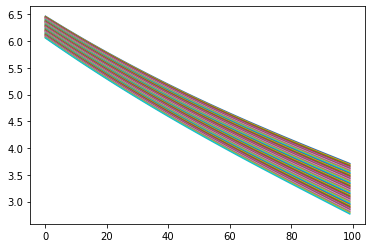

In [59]:
plt.plot(ϕ_i[0])
plt.show()

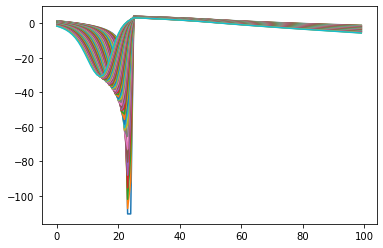

In [60]:
plt.plot(ϕ_i[1])
plt.show()

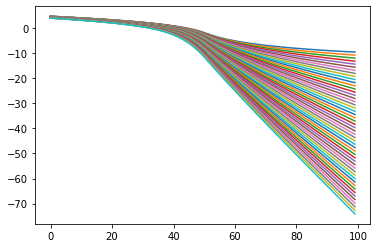

In [61]:
plt.plot(ϕ_i[2])
plt.show()

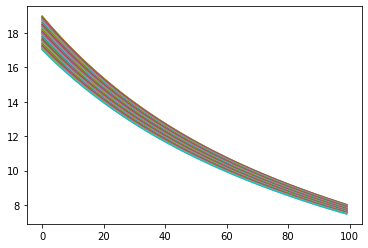

In [62]:
plt.plot(ems_i[0])
plt.show()

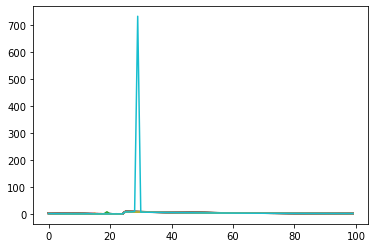

In [63]:
plt.plot(ems_i[1])
plt.show()

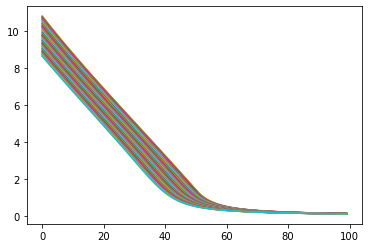

In [64]:
plt.plot(ems_i[2])
plt.show()

In [23]:
def false_transient_robust(y1_grid, y2_grid, model_paras=(), v0=None, ϵ=.5, tol=1e-8, max_iter=10_000, print_all=True):
    η, δ, θ, γ_1, γ_2, πc_o, πd_o, ξ_a, ξ_p, ϕ_i = model_paras
    dy1 = y1_grid[1] - y1_grid[0]
    dy2 = y2_grid[1] - y2_grid[0]
    (y1_mat, y2_mat) = np.meshgrid(y1_grid, y2_grid, indexing = 'ij')
    stateSpace = np.hstack([y1_mat.reshape(-1, 1, order='F'), y2_mat.reshape(-1, 1, order='F')])    

    if v0 is None:
        v0 = -η*(y1_mat+y2_mat+(y1_mat+y2_mat)**2)

    d_Λ = γ_1 + γ_2*y1_mat

    πd = np.ones((len(πd_o), len(y1_grid), len(y2_grid)))
    for i in range(πd.shape[0]):
        πd[i] = πd_o[i]
    πd_o = πd

    πc = np.ones((len(πc_o), len(y1_grid), len(y2_grid)))
    θ_reshape = np.ones_like(πc)
    for i in range(πc.shape[0]):
        πc[i] = πc_o[i]
        θ_reshape[i] = θ[i]
    πc_o = πc.copy()
    θ = θ_reshape

    bc_y = -ξ_p*np.log(np.sum(πd_o[:, -1, :]*np.exp(-1./ξ_p*ϕ_i[:, -1, :]), axis=0))
    bc = (np.zeros(0), bc_y, np.zeros(0), np.zeros(0))
    impose_bc = (False, True, False, False)

    count = 0
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()

        v0_dy1 = compute_derivatives(v0, 0, 1, dy1)
        v0_dy2 = compute_derivatives(v0, 1, 1, dy2)        

        e_tilde = -η/(v0_dy2*λ*np.sum(πc*θ, axis=0))
        e_tilde[e_tilde<=0] = 1e-15

        log_πc_ratio = -v0_dy2*λ*e_tilde*θ/ξ_a
        πc_ratio = log_πc_ratio - np.max(log_πc_ratio, axis=0)
        πc = np.exp(πc_ratio) * πc_o
        πc = πc/np.sum(πc, axis=0)
        πc[πc<=0] = 1e-16
        c_entropy = np.sum(πc*(np.log(πc)-np.log(πc_o)), axis=0)

        A = np.ones_like(y1_mat) * (-δ)
        B1 = y2_mat
        B2 = λ*(-y2_mat+np.sum(πc_o*θ, axis=0)*e_tilde)
        C1 = np.zeros_like(y1_mat)
        C2 = np.zeros_like(y2_mat)
        D = η*np.log(e_tilde) + (η-1)/δ*d_Λ*y2_mat + ξ_a * c_entropy

        v0 = false_transient_one_iteration_python(A, B1, B2, C1, C2, D, v0, ϵ, dy1, dy2, bc, impose_bc) # CG tol = 1e-10

        rhs_error = A*v0 + B1*v0_dy1 + B2*v0_dy2 + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
        count += 1
        if print_all:
            print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

    print("Converged. Total iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

    res = {'v0': v0,
           'e_tilde': e_tilde}
    return res

In [26]:
nbar = int(y_bar/y1_step) + 1
ϕ_i_short = np.array([temp[:nbar, :] for temp in ϕ_i])
model_paras = (η, δ, θ, γ_1, γ_2, πc_o, πd_o, ξ_a, ξ_p, ϕ_i_short)
model_res = false_transient_robust(y1_grid_short, y2_grid, model_paras,
                                   v0=np.average(ϕ_i_short, weights=πd_o, axis=0),
                                   ϵ=.3, tol=1e-8, max_iter=1000, print_all=True)

Iteration 1: LHS Error: 14.828196889586213; RHS Error 0.0644755397899896
Iteration 2: LHS Error: 2.6240032868787617; RHS Error 3.176429822589759
Iteration 3: LHS Error: 1.832665986059309; RHS Error 2.212108614660604
Iteration 4: LHS Error: 1.2879566908672135; RHS Error 1.5386038648469254
Iteration 5: LHS Error: 1.1187602223409807; RHS Error 1.06527978088345
Iteration 6: LHS Error: 0.9492252693781422; RHS Error 0.8669005083995489
Iteration 7: LHS Error: 0.7871098239163506; RHS Error 0.7323402796673109
Iteration 8: LHS Error: 0.690378669829889; RHS Error 0.6005704896677426
Iteration 9: LHS Error: 0.6175142812736494; RHS Error 0.4852090763884529
Iteration 10: LHS Error: 0.5427630002116753; RHS Error 0.43112872647918593
Iteration 11: LHS Error: 0.4728263228604779; RHS Error 0.37431530115735256
Iteration 12: LHS Error: 0.43494946317525596; RHS Error 0.31835512782420194
Iteration 13: LHS Error: 0.3940784651935222; RHS Error 0.2676638463258713
Iteration 14: LHS Error: 0.3551665076049412; RHS 

Iteration 112: LHS Error: 0.020466188225046388; RHS Error 0.14975846310758192
Iteration 113: LHS Error: 0.020283012162992296; RHS Error 0.1497310279682085
Iteration 114: LHS Error: 0.020095781356996856; RHS Error 0.1497548061226323
Iteration 115: LHS Error: 0.01999458633620499; RHS Error 0.14972774488567847
Iteration 116: LHS Error: 0.019924916503602695; RHS Error 0.14975007657715922
Iteration 117: LHS Error: 0.019851487369477727; RHS Error 0.14972362220953353
Iteration 118: LHS Error: 0.019774192379220512; RHS Error 0.14974401152378888
Iteration 119: LHS Error: 0.019693197840859877; RHS Error 0.14971825614302897
Iteration 120: LHS Error: 0.01960837587906254; RHS Error 0.14973580858396224
Iteration 121: LHS Error: 0.019519920590076456; RHS Error 0.14971129250211074
Iteration 122: LHS Error: 0.01942767442714155; RHS Error 0.1497244367338915
Iteration 123: LHS Error: 0.019331872663261123; RHS Error 0.14970141045695054
Iteration 124: LHS Error: 0.019232307034657836; RHS Error 0.1497060865

Iteration 220: LHS Error: 0.011873368227455217; RHS Error 0.14972348660154966
Iteration 221: LHS Error: 0.011820971300274449; RHS Error 0.1497977727660922
Iteration 222: LHS Error: 0.011767238658260126; RHS Error 0.14962314222160816
Iteration 223: LHS Error: 0.011712063715966597; RHS Error 0.14964898839651408
Iteration 224: LHS Error: 0.01165542312226838; RHS Error 0.14969844932767748
Iteration 225: LHS Error: 0.01159740917875111; RHS Error 0.14963965825522893
Iteration 226: LHS Error: 0.01153802291094556; RHS Error 0.14966431569484895
Iteration 227: LHS Error: 0.01147715295895561; RHS Error 0.14969380151104594
Iteration 228: LHS Error: 0.011414937586569826; RHS Error 0.14969770832997978
Iteration 229: LHS Error: 0.011371467672547375; RHS Error 0.1497114977588193
Iteration 230: LHS Error: 0.011332804187461262; RHS Error 0.14979045370593203
Iteration 231: LHS Error: 0.011292959197621855; RHS Error 0.1497424560685132
Iteration 232: LHS Error: 0.01125175966980289; RHS Error 0.149876968564

Iteration 328: LHS Error: 0.00765011501667523; RHS Error 0.14980178364510963
Iteration 329: LHS Error: 0.00762382673214083; RHS Error 0.1497679595531899
Iteration 330: LHS Error: 0.007596863999498697; RHS Error 0.14978296074142097
Iteration 331: LHS Error: 0.007569243121377708; RHS Error 0.14976594514020714
Iteration 332: LHS Error: 0.007540953859185666; RHS Error 0.14982105643144217
Iteration 333: LHS Error: 0.007511961711054542; RHS Error 0.14992787363758742
Iteration 334: LHS Error: 0.00748233024817561; RHS Error 0.14980192273465182
Iteration 335: LHS Error: 0.007452018875720631; RHS Error 0.14980002638434836
Iteration 336: LHS Error: 0.00742104094404598; RHS Error 0.14976566311807207
Iteration 337: LHS Error: 0.007389393129814496; RHS Error 0.14977668625015317
Iteration 338: LHS Error: 0.0073599965314426665; RHS Error 0.14981387283193917
Iteration 339: LHS Error: 0.007336265992770782; RHS Error 0.14970422649449694
Iteration 340: LHS Error: 0.007311905894923735; RHS Error 0.14970083

Iteration 436: LHS Error: 0.005169870422760958; RHS Error 0.14984619078159872
Iteration 437: LHS Error: 0.005151958160845757; RHS Error 0.14973608990823856
Iteration 438: LHS Error: 0.005133608142625276; RHS Error 0.14975343692381107
Iteration 439: LHS Error: 0.005114987185922774; RHS Error 0.14964439361458676
Iteration 440: LHS Error: 0.005095896504771306; RHS Error 0.14970310959676747
Iteration 441: LHS Error: 0.005076407116394085; RHS Error 0.1498372800443988
Iteration 442: LHS Error: 0.005059211990894319; RHS Error 0.14994904935352724
Iteration 443: LHS Error: 0.005043128563676133; RHS Error 0.14996787288809416
Iteration 444: LHS Error: 0.005026525651616136; RHS Error 0.1497451677329753
Iteration 445: LHS Error: 0.005009613407899553; RHS Error 0.14978427149583795
Iteration 446: LHS Error: 0.004992363673964976; RHS Error 0.14976519603238736
Iteration 447: LHS Error: 0.004974750477860409; RHS Error 0.1497575160399785
Iteration 448: LHS Error: 0.004956769416917991; RHS Error 0.1497446

Iteration 544: LHS Error: 0.0035726172470755086; RHS Error 0.14971327719823135
Iteration 545: LHS Error: 0.0035607229590883804; RHS Error 0.14971476782503185
Iteration 546: LHS Error: 0.0035495300721540466; RHS Error 0.14970541852455632
Iteration 547: LHS Error: 0.0035380699583420494; RHS Error 0.14970559897079636
Iteration 548: LHS Error: 0.0035264009806409056; RHS Error 0.14970998841123018
Iteration 549: LHS Error: 0.0035145805758910837; RHS Error 0.14974141772547178
Iteration 550: LHS Error: 0.003502309829540214; RHS Error 0.14977515265520777
Iteration 551: LHS Error: 0.0034900045983447354; RHS Error 0.14984554214640536
Iteration 552: LHS Error: 0.0034786443097771054; RHS Error 0.14967581887253328
Iteration 553: LHS Error: 0.003467603126209677; RHS Error 0.14969108861076164
Iteration 554: LHS Error: 0.0034564223200087936; RHS Error 0.14969136053587395
Iteration 555: LHS Error: 0.0034449806288527896; RHS Error 0.1496961243645755
Iteration 556: LHS Error: 0.0034333319696363183; RHS Er

Iteration 649: LHS Error: 0.0023315184657561145; RHS Error 0.1496695319625866
Iteration 650: LHS Error: 0.0023147001481375424; RHS Error 0.14967399301354256
Iteration 651: LHS Error: 0.002297735083862662; RHS Error 0.14968939232487188
Iteration 652: LHS Error: 0.0022806765793544534; RHS Error 0.1496936074865775
Iteration 653: LHS Error: 0.0022635103960144676; RHS Error 0.14970251334025542
Iteration 654: LHS Error: 0.0022461686986681904; RHS Error 0.14976025539132062
Iteration 655: LHS Error: 0.0022287578394427263; RHS Error 0.14983721754697615
Iteration 656: LHS Error: 0.0022112221114974537; RHS Error 0.14970182302538998
Iteration 657: LHS Error: 0.002193616297653615; RHS Error 0.14973216335135556
Iteration 658: LHS Error: 0.0021758771495120994; RHS Error 0.14961829115461317
Iteration 659: LHS Error: 0.0021580142449491766; RHS Error 0.1496494909037441
Iteration 660: LHS Error: 0.002140121955690096; RHS Error 0.14965310470568735
Iteration 661: LHS Error: 0.0021221149225662357; RHS Error

Iteration 754: LHS Error: 0.0005757054317090393; RHS Error 0.14973835618154024
Iteration 755: LHS Error: 0.0006174257920399384; RHS Error 0.14973895122216035
Iteration 756: LHS Error: 0.0005579153431186276; RHS Error 0.14975749135031863
Iteration 757: LHS Error: 0.00068886903829668; RHS Error 0.14975675169959551
Iteration 758: LHS Error: 0.0016650154007979978; RHS Error 0.14983145257674366
Iteration 759: LHS Error: 0.0010980811926971277; RHS Error 0.14969343235384497
Iteration 760: LHS Error: 0.0005121464296416652; RHS Error 0.1497168016824595
Iteration 761: LHS Error: 0.0006196446421894801; RHS Error 0.1497594135527735
Iteration 762: LHS Error: 0.0004921966054786491; RHS Error 0.14972895053986307
Iteration 763: LHS Error: 0.00048242537239081196; RHS Error 0.14974362242581396
Iteration 764: LHS Error: 0.0005780863777848921; RHS Error 0.14972260349458602
Iteration 765: LHS Error: 0.0005448818729962095; RHS Error 0.14974194011084652
Iteration 766: LHS Error: 0.001038077369911091; RHS Err

Iteration 859: LHS Error: 0.00016025970638840667; RHS Error 0.1497172519047083
Iteration 860: LHS Error: 0.0010238170756767437; RHS Error 0.1497205911565806
Iteration 861: LHS Error: 0.00028887701137995475; RHS Error 0.14976670564892608
Iteration 862: LHS Error: 0.0005559714127641632; RHS Error 0.14980278639502603
Iteration 863: LHS Error: 0.0009471463725363449; RHS Error 0.14977241329983673
Iteration 864: LHS Error: 0.002012092530455275; RHS Error 0.14982819005488984
Iteration 865: LHS Error: 0.0008433204858556328; RHS Error 0.14964162234649808
Iteration 866: LHS Error: 0.000525211852435703; RHS Error 0.14965861409211176
Iteration 867: LHS Error: 0.0011417864373486353; RHS Error 0.14967138404572988
Iteration 868: LHS Error: 0.0006471833353301667; RHS Error 0.149707303924417
Iteration 869: LHS Error: 0.00031477275624247625; RHS Error 0.1497005257479051
Iteration 870: LHS Error: 0.00020430258583263122; RHS Error 0.14969541495135583
Iteration 871: LHS Error: 0.0006473400323736556; RHS Er

Iteration 964: LHS Error: 0.00021058402408661675; RHS Error 0.1497525922667322
Iteration 965: LHS Error: 0.0008476577526739248; RHS Error 0.14974385685671762
Iteration 966: LHS Error: 0.0006861510578544857; RHS Error 0.14977078385299852
Iteration 967: LHS Error: 0.00031599283679906165; RHS Error 0.14973089248614435
Iteration 968: LHS Error: 0.0005667313801493989; RHS Error 0.14971819843745798
Iteration 969: LHS Error: 0.0003301646628709835; RHS Error 0.14972904863623043
Iteration 970: LHS Error: 0.00018093304006816524; RHS Error 0.14971922717053437
Iteration 971: LHS Error: 0.0006112028836543123; RHS Error 0.14971674090217146
Iteration 972: LHS Error: 0.00020632347360457123; RHS Error 0.14974250061469604
Iteration 973: LHS Error: 0.0007592356226338026; RHS Error 0.14975223276454921
Iteration 974: LHS Error: 0.00034893137127234297; RHS Error 0.14981851308617342
Iteration 975: LHS Error: 0.0008542294326163713; RHS Error 0.14981637465668546
Iteration 976: LHS Error: 0.0004911139331727673;

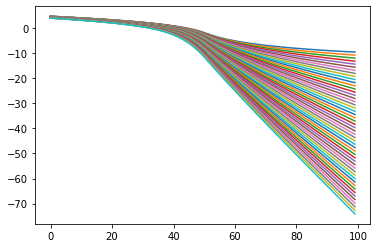

In [35]:
plt.plot(model_res['v0'])

In [28]:
np.save('emission_two_state', model_res['e_tilde'])

In [47]:
ems_i_short = np.array([temp[:nbar, :] for temp in ems_i])
np.save('emission_two_state_low', ems_i[0])
np.save('emission_two_state_high', ems_i[1])
np.save('emission_two_state_extreme', ems_i[2])